<a href="https://colab.research.google.com/github/gringonivoli/diplo2020-mentoria-prediccion-lluvias-extremas/blob/master/TP3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## TP3: Aprendizaje supervizado

In [3]:
import pandas as pd
import numpy as np

In [4]:
Datos = pd.read_csv("https://raw.githubusercontent.com/Rondamon/2020_Mentoria_LluviasExtremas/master/dataset/datos_diarios_cordoba.csv", parse_dates = True, index_col="fecha")
id_Datos = pd.read_csv("https://raw.githubusercontent.com/Rondamon/2020_Mentoria_LluviasExtremas/master/dataset/metadatos_estaciones.csv")

De los datasets analizados en los TPs anteriores, ahora nos vamos a enfocar en:

- La Florida
- Marcos Juarez

Y vamos a usar como variable que queremos predecir, la PMDA que han calculado para cada año hidrológico (del 1/julio al 30/junio).

Las demás variables (como viento, temperatura, etc) las vamos a resumir para cada año hidrológico en la media (se pueden agregar más estadísticos pero así es suficiente).

##### Actividades:

##### OBJETIVO: Predecir Precipitación Máxima Diaria Anual (PMDA) para los próximos 5 años

**1**) De los dataset que han trabajado hasta ahora, agreguen más features al DataFrame **"Datos"** (Por lo general, más features tienden a dar mejores predicciones).

2) Además de las features del punto anterior, les propongo agregar nuevas features moviendo las originales tantos "pasos de tiempo" como features nuevas quieran generar.

3) Curar el dataset (si fuera necesario).

4) Aplicar técnicas de selección y extraccion de features. Armar un nuevo dataset con aquellas features más significativas.

5) Dividir el dataset (training, validation, test).. Recuerden que queremos predecir la PMDA para los próximos 5 años.

6) Analizar y elegir 3 modelos para REGRESIÓN. Entrenarlos y analizar resultados.

7) Evaluar predicciones de los diferentes modelos.

8) ¿Qué estadísticos utilizaron para evaluar las regresiones? Justifiquen su elección.

In [ ]:
full_dataset = pd.read_csv('https://raw.githubusercontent.com/gringonivoli/diplo2020-mentoria-prediccion-lluvias-extremas/master/datasetTP2/datos_diarios_cordoba_terra_chirps.csv')


Se cargan los valores de índices climáticos usados en el TP2 que condicionan el clima regional. Se resumen por año hidrológico en distintas métricas: media, máximo y mínimo. Algunos indican sequías con valores positivos y otros negativos.

Se podrían agregar más! Sólo elegí tres a modo de ejemplo.

In [7]:
dataset_indices = pd.read_csv('https://raw.githubusercontent.com/gringonivoli/diplo2020-mentoria-prediccion-lluvias-extremas/master/datasetTP2/indices_climaticos_corregidos.csv')

dataset_indices = dataset_indices[['hydro_year', 'SOI', 'ONI', 'Nino 3+4', 'PDO']]
dataset_indices = dataset_indices.groupby(['hydro_year', ]).agg(
    SOI_mean = ('SOI','mean'),
    SOI_max = ('SOI','max'),
    SOI_min = ('SOI','min'),
    ONI_mean = ('ONI','mean'),
    ONI_max = ('ONI','max'),
    ONI_min = ('ONI','min'),
    Nino_3_4_mean = ('Nino 3+4','mean'),
    Nino_3_4_max = ('Nino 3+4','max'),
    Nino_3_4_min = ('Nino 3+4','min'),
    PDO_mean = ('PDO','mean'),
    PDO_max = ('PDO','max'),
    PDO_min = ('PDO','min')


)                                                          
                                                                 

dataset_indices.head()


,SOI_mean,SOI_max,SOI_min,ONI_mean,ONI_max,ONI_min,Nino_3_4_mean,Nino_3_4_max,Nino_3_4_min,PDO_mean,PDO_max,PDO_min
hydro_year,,,,,,,,,,,,
1947,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.488000,-0.03,-1.33
1948,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.355000,0.08,-3.60
1949,NaN,NaN,NaN,-1.256000,-1.07,-1.53,25.588000,26.28,24.55,-1.344167,-0.56,-2.91
1950,0.440000,2.5,-1.1,-0.419167,0.36,-0.85,26.180833,27.92,25.24,-1.435833,-0.25,-2.93
1951,-0.708333,1.2,-1.8,0.657500,1.15,0.20,27.259167,27.80,26.67,-0.772500,0.70,-2.01


In [8]:
import datetime as dt

dataset_indices_ond = pd.read_csv('https://raw.githubusercontent.com/gringonivoli/diplo2020-mentoria-prediccion-lluvias-extremas/master/datasetTP2/indices_climaticos_corregidos.csv', parse_dates = True)

dataset_indices_ond.loc[:, 'date'] = pd.to_datetime(dataset_indices_ond.fix_date)
dataset_indices_ond.loc[:,'mes'] = dataset_indices_ond.loc[:,'date'].dt.month


mes = [10, 11, 12]
dataset_indices_ond = dataset_indices_ond[dataset_indices_ond.mes.isin(mes)]

dataset_indices_ond = dataset_indices_ond[['hydro_year', 'SOI', 'ONI', 'Nino 3+4', 'PDO']]
dataset_indices_ond = dataset_indices_ond.groupby(['hydro_year', ]).agg(
    SOI_OND_mean = ('SOI','mean'),
    SOI_OND_max = ('SOI','max'),
    SOI_OND_min = ('SOI','min'),
    ONI_OND_mean = ('ONI','mean'),
    ONI_OND_max = ('ONI','max'),
    ONI_OND_min = ('ONI','min'),
    Nino_3_4_OND_mean = ('Nino 3+4','mean'),
    Nino_3_4_OND_max = ('Nino 3+4','max'),
    Nino_3_4_OND_min = ('Nino 3+4','min'),
    PDO_OND_mean = ('PDO','mean'),
    PDO_OND_max = ('PDO','max'),
    PDO_OND_min = ('PDO','min')


)       


dataset_indices_ond.head()

,SOI_OND_mean,SOI_OND_max,SOI_OND_min,ONI_OND_mean,ONI_OND_max,ONI_OND_min,Nino_3_4_OND_mean,Nino_3_4_OND_max,Nino_3_4_OND_min,PDO_OND_mean,PDO_OND_max,PDO_OND_min
hydro_year,,,,,,,,,,,,
1948,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.303333,-0.89,-1.70
1949,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.013333,-0.80,-1.41
1950,NaN,NaN,NaN,-0.613333,-0.44,-0.80,25.483333,25.69,25.29,-1.526667,-0.76,-2.46
1951,-1.366667,-1.2,-1.6,1.000000,1.15,0.81,27.120000,27.25,26.91,-0.760000,-0.28,-1.68
1952,-0.466667,0.6,-2.0,0.096667,0.15,0.04,26.130000,26.26,25.92,-0.356667,0.04,-0.76


Armé un dataset en función de si es un año Niño (más lluvias) o Nina (menos lluvias) o neutro. 

In [9]:
dataset_tipo_ano = pd.read_csv('https://raw.githubusercontent.com/gringonivoli/diplo2020-mentoria-prediccion-lluvias-extremas/master/Dataset%20TP3/tipo_ano.csv', sep = ';')


dataset_tipo_ano.head()


,hydro_year,type_category
0,1960,Neutral
1,1961,Neutral
2,1962,Neutral
3,1963,Warm
4,1964,Cold


In [10]:
full_dataset.nombre.unique()

array(['Pilar Obs.', 'Rio Cuarto Aero', 'Marcos Juarez INTA',
       'La Florida'], dtype=object)

Se filtran las estaciones de La Florida y marcos Juarez

In [11]:
dataset = full_dataset[(full_dataset['nombre'] == 'La Florida') | (full_dataset['nombre'] == 'Marcos Juarez INTA')]
dataset.loc[:, 'fecha'] = pd.to_datetime(dataset['fecha'])
dataset.reset_index(inplace=True)
dataset = dataset.drop(['Unnamed: 0'], axis=1)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [12]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

In [13]:
def get_hydro_year(date_, start_month=7):
    year = date_.strftime('%Y')
    month = date_.strftime('%m')
    offset = 1 if int(month) >= start_month - 1 else 0
    hydro_year = int(year) + offset - 1
    return hydro_year

def add_hydro_year(dataset):
    dataset = dataset.copy()
    dataset.reset_index(inplace=True)
    dataset['hydro_year'] = dataset['fecha'].apply(get_hydro_year)
    return dataset

def remove_cols(dataset, cols=['level_0', 'ano', 'mes', 'caudal', 'tmed', 'vmax_d', 'vmax_f']):
    return dataset.drop(cols, axis=1)

def get_grouped_dataset(dataset, group=['omm_id', 'hydro_year']):
    return dataset.groupby(group)

def derive_nth_day_feature(df, feature, N):
    rows = df.shape[0]
    nth_prior_measurements = [None]*N + [df[feature].iloc[i-N] for i in range(N, rows)]
    col_name = "{}_{}".format(feature, N)
    df[col_name] = nth_prior_measurements
    
def number_days_over_threshold(dataset, threshold = 10):
    rainfall_data = dataset.copy()
    rainfall_data = rainfall_data[['omm_id', 'hydro_year', 'prcp']]
    rainfall_data['day_beyond_threshold'] = rainfall_data.prcp > threshold
    rainfall_data = rainfall_data.groupby(['omm_id', 'hydro_year'], as_index=False).day_beyond_threshold.sum()
    return(rainfall_data)

def rainy_days_over_percentile(dataset, threshold = 0.9):
    rainfall_data = dataset.copy()
    rainfall_data = rainfall_data[['omm_id', 'hydro_year', 'prcp']]
    rainfall_data = rainfall_data[rainfall_data.prcp > 0.1]
    reference_quantiles = rainfall_data.groupby(['omm_id'], as_index=False).prcp.quantile(threshold)
    reference_quantiles.rename(columns={'prcp': 'prcp_threshold'}, inplace=True) 
    rainfall_data = pd.merge(rainfall_data, reference_quantiles, on = 'omm_id')
    rainfall_data['day_beyond_threshold'] = rainfall_data.prcp > rainfall_data.prcp_threshold    
    rainfall_data = rainfall_data.groupby(['omm_id', 'hydro_year'], as_index=False).day_beyond_threshold.sum()
    return(rainfall_data)

def add_days_over_threshold(dataset_yearly, dataset, threshold):
    dataset_ = number_days_over_threshold(dataset, threshold)
    dataset_ = dataset_.rename(columns = {'day_beyond_threshold': f'day_{threshold}_mm'})
    return pd.merge(dataset_yearly, dataset_, on = ['hydro_year', 'omm_id'])

def add_days_over_percentile(dataset_yearly, dataset, threshold):
    dataset_ = rainy_days_over_percentile(dataset, threshold)
    dataset_ = dataset_.rename(columns = {'day_beyond_threshold': f'day_{int(100 * threshold)}'})
    return pd.merge(dataset_yearly, dataset_, on = ['hydro_year', 'omm_id'])

def add_lagged_features(dataset_, columns, N):
    dataset = dataset_.copy()
    for feature in columns:
        #if feature != 'PMDA':
         #   for n in range(1, N):
        derive_nth_day_feature(dataset, feature, N)
    return dataset

Se agrega el año hidrológico.

In [14]:
dataset = add_hydro_year(dataset)

In [15]:
dataset.head()

,level_0,index,fecha,ano,mes,omm_id,nombre,prcp,tmax,tmin,tmed,vmax_d,vmax_f,vmed,caudal,ETreal_mm,HumedadSuelo_mm,RadSolar_Wpm2,PresionVapor_hPa,IndicePalmer_porc,hydro_year
0,0,43473,1967-10-01,1967,10,87466,Marcos Juarez INTA,0.0,25.8,11.7,NaN,NaN,NaN,3.333333,NaN,NaN,NaN,NaN,NaN,NaN,1967
1,1,43474,1967-10-02,1967,10,87466,Marcos Juarez INTA,7.5,25.0,14.4,NaN,NaN,NaN,4.444444,NaN,NaN,NaN,NaN,NaN,NaN,1967
2,2,43475,1967-10-03,1967,10,87466,Marcos Juarez INTA,21.0,23.4,13.2,NaN,NaN,NaN,6.666667,NaN,NaN,NaN,NaN,NaN,NaN,1967
3,3,43476,1967-10-04,1967,10,87466,Marcos Juarez INTA,0.0,21.2,14.0,NaN,NaN,NaN,1.944444,NaN,NaN,NaN,NaN,NaN,NaN,1967
4,4,43477,1967-10-05,1967,10,87466,Marcos Juarez INTA,0.0,22.5,11.0,NaN,NaN,NaN,5.833333,NaN,NaN,NaN,NaN,NaN,NaN,1967


Las variables diarias se agregan por año hidrológico. En lugar de sólo calular la media o máxima, generé más features como los valores mínimos, desvíos. También estandaricé y normalicé algunas de las variables. Usé una ventana movil de 5 años porque el profe quería un pronóstico a cinco años, entonces generé variables que ponderan los valores en ventanas de 5 años. 

In [16]:
dataset = dataset[dataset.hydro_year >= 1961]
dataset_yearly = dataset.groupby(['hydro_year', 'omm_id', 'nombre']).agg(
                                                                         PMDA = ('prcp', max), 
                                                                         prcp = ('prcp', sum),
                                                                         prcp_sd = ('prcp', 'std'),
                                                                         prcp_mad = ('prcp', 'mad'), 
                                                                         tmax_max = ('tmax', max),
                                                                         tmax_mean = ('tmax', 'mean'),
                                                                         tmax_sd = ('tmax', 'std'),
                                                                         tmax_min = ('tmax', min),
                                                                         tmin_max = ('tmin', max),
                                                                         tmin_mean = ('tmin', 'mean'),
                                                                         tmin_min = ('tmin', min),
                                                                         tmin_sd = ('tmin', 'std'),
                                                                         vmed_max = ('vmed', max),
                                                                         vmed_mean = ('vmed', 'mean'),
                                                                         vmed_min = ('vmed', min),
                                                                         vmed_sd = ('vmed', 'std')
                                                                         #caudal_max = ('caudal', max),
                                                                         #caudal_mean = ('caudal', 'mean'),
                                                                         #caudal_min = ('caudal', min)
                                                                         )
# Variables derivadas de la precipitacion
dataset_yearly['PMDA_log'] = dataset_yearly.PMDA.transform(np.log)
dataset_yearly['prcp_log'] = dataset_yearly.prcp.transform(np.log)
dataset_yearly['prcp_standardized'] = (dataset_yearly['prcp'] - dataset_yearly['prcp'].mean()) / dataset_yearly['prcp'].std()
dataset_yearly['prcp_normalized'] = (dataset_yearly['prcp'] - dataset_yearly['prcp'].min()) / (dataset_yearly['prcp'].max() - dataset_yearly['prcp'].min())
dataset_yearly['prcp_standardized_rolling'] = dataset_yearly.groupby(['omm_id', 'nombre']).rolling(3)['prcp_standardized'].mean().droplevel(level=[0,1])
dataset_yearly['prcp_normalized_rolling'] = dataset_yearly.groupby(['omm_id', 'nombre']).rolling(3)['prcp_normalized'].mean().droplevel(level=[0,1])
dataset_yearly['prcp_log_rolling'] = dataset_yearly.groupby(['omm_id', 'nombre']).rolling(3)['prcp_log'].mean().droplevel(level=[0,1])
dataset_yearly['PMDA_log_rolling'] = dataset_yearly.groupby(['omm_id', 'nombre']).rolling(3)['PMDA_log'].mean().droplevel(level=[0,1])
dataset_yearly['PMDA_rolling'] = dataset_yearly.groupby(['omm_id', 'nombre']).rolling(3)['PMDA'].mean().droplevel(level=[0,1])
dataset_yearly['prcp_rolling'] = dataset_yearly.groupby(['omm_id', 'nombre']).rolling(3)['prcp'].mean().droplevel(level=[0,1])

# Variables derivadas de la temperatura media
dataset_yearly['tmed_max'] = (dataset_yearly.tmax_max + dataset_yearly.tmin_max)/2
dataset_yearly['tmed_mean'] = (dataset_yearly.tmax_mean + dataset_yearly.tmin_mean)/2
dataset_yearly['tmed_min'] = (dataset_yearly.tmax_min + dataset_yearly.tmin_min)/2
dataset_yearly['tmed_range'] = dataset_yearly.tmed_max - dataset_yearly.tmed_min
dataset_yearly['tmed_standardized'] = (dataset_yearly['tmed_mean'] - dataset_yearly['tmed_mean'].mean()) / dataset_yearly['tmed_mean'].std()
dataset_yearly['tmed_normalized'] = (dataset_yearly['tmed_mean'] - dataset_yearly['tmed_mean'].min()) / (dataset_yearly['tmed_mean'].max() - dataset_yearly['tmed_mean'].min())

# Variables derivadas de la temperatura maxima
dataset_yearly['tmax_range'] = dataset_yearly.tmax_max - dataset_yearly.tmax_min
dataset_yearly['tmax_standardized'] = (dataset_yearly['tmax_mean'] - dataset_yearly['tmax_mean'].mean()) / dataset_yearly['tmax_mean'].std()
dataset_yearly['tmax_normalized'] = (dataset_yearly['tmax_mean'] - dataset_yearly['tmax_mean'].min()) / (dataset_yearly['tmax_mean'].max() - dataset_yearly['tmax_mean'].min())
#dataset_yearly['tmax_standardized_rolling'] = dataset_yearly.groupby(['omm_id', 'nombre']).rolling(5)['tmax_mean'].mean().droplevel(level=[0,1])
#dataset_yearly['tmax_normalized_rolling'] = dataset_yearly.groupby(['omm_id', 'nombre']).rolling(5)['tmax_mean'].mean().droplevel(level=[0,1])
#dataset_yearly['tmax_min_rolling'] = dataset_yearly.groupby(['omm_id', 'nombre']).rolling(5)['tmax_mean'].mean().droplevel(level=[0,1])
#dataset_yearly['tmax_max_rolling'] = dataset_yearly.groupby(['omm_id', 'nombre']).rolling(5)['tmax_mean'].mean().droplevel(level=[0,1])
#dataset_yearly['tmax_mean_rolling'] = dataset_yearly.groupby(['omm_id', 'nombre']).rolling(5)['tmax_mean'].mean().droplevel(level=[0,1])
#dataset_yearly['tmax_range_rolling'] = dataset_yearly.groupby(['omm_id', 'nombre']).rolling(5)['tmax_mean'].mean().droplevel(level=[0,1])

# Variables derivadas de la temperatura minima
dataset_yearly['tmin_range'] = dataset_yearly.tmin_max - dataset_yearly.tmin_min
dataset_yearly['tmin_standardized'] = (dataset_yearly['tmin_mean'] - dataset_yearly['tmin_mean'].mean()) / dataset_yearly['tmin_mean'].std()
dataset_yearly['tmin_normalized'] = (dataset_yearly['tmin_mean'] - dataset_yearly['tmin_mean'].min()) / (dataset_yearly['tmin_mean'].max() - dataset_yearly['tmin_mean'].min())
#dataset_yearly['tmin_standardized_rolling'] = dataset_yearly.groupby(['omm_id', 'nombre']).rolling(5)['tmin_mean'].mean().droplevel(level=[0,1])
#dataset_yearly['tmin_normalized_rolling'] = dataset_yearly.groupby(['omm_id', 'nombre']).rolling(5)['tmin_mean'].mean().droplevel(level=[0,1])
#dataset_yearly['tmin_min_rolling'] = dataset_yearly.groupby(['omm_id', 'nombre']).rolling(5)['tmin_mean'].mean().droplevel(level=[0,1])
#dataset_yearly['tmin_max_rolling'] = dataset_yearly.groupby(['omm_id', 'nombre']).rolling(5)['tmin_mean'].mean().droplevel(level=[0,1])
#dataset_yearly['tmin_mean_rolling'] = dataset_yearly.groupby(['omm_id', 'nombre']).rolling(5)['tmin_mean'].mean().droplevel(level=[0,1])
#dataset_yearly['tmin_range_rolling'] = dataset_yearly.groupby(['omm_id', 'nombre']).rolling(5)['tmin_mean'].mean().droplevel(level=[0,1])

# Variables derivadas del viento
dataset_yearly['vmed_log'] = dataset_yearly.vmed_mean.transform(np.log)
dataset_yearly['vmed_standardized'] = (dataset_yearly['vmed_mean'] - dataset_yearly['vmed_mean'].mean()) / dataset_yearly['vmed_mean'].std()
dataset_yearly['vmed_normalized'] = (dataset_yearly['vmed_mean'] - dataset_yearly['vmed_mean'].min()) / (dataset_yearly['vmed_mean'].max() - dataset_yearly['vmed_mean'].min())


dataset_yearly.head()


,,,PMDA,prcp,prcp_sd,prcp_mad,tmax_max,tmax_mean,tmax_sd,tmax_min,tmin_max,tmin_mean,tmin_min,tmin_sd,vmed_max,vmed_mean,vmed_min,vmed_sd,PMDA_log,prcp_log,prcp_standardized,prcp_normalized,prcp_standardized_rolling,prcp_normalized_rolling,prcp_log_rolling,PMDA_log_rolling,PMDA_rolling,prcp_rolling,tmed_max,tmed_mean,tmed_min,tmed_range,tmed_standardized,tmed_normalized,tmax_range,tmax_standardized,tmax_normalized,tmin_range,tmin_standardized,tmin_normalized,vmed_log,vmed_standardized,vmed_normalized
hydro_year,omm_id,nombre,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1961,1,La Florida,86.5,808.8,12.309957,6.483464,26.9,20.622466,4.955493,12.6,11.6,6.174247,-0.5,4.392619,5.06,4.170274,3.26,0.525750,4.460144,6.695552,-0.467900,0.347015,NaN,NaN,NaN,NaN,NaN,NaN,19.25,13.398356,6.05,13.20,-0.970311,0.324107,14.3,-0.796908,0.327774,12.1,-1.073738,0.303852,1.427982,0.503996,0.815187
1962,1,La Florida,59.0,516.5,9.435875,4.989736,26.8,20.723288,5.323634,9.9,12.5,6.183014,-3.1,5.380529,5.06,4.354575,3.81,0.345748,4.077537,6.247075,-1.688642,0.139799,NaN,NaN,NaN,NaN,NaN,NaN,19.65,13.453151,3.40,16.25,-0.945712,0.330086,16.9,-0.745777,0.338568,15.6,-1.070317,0.304778,1.471227,0.667818,0.862385
1963,1,La Florida,53.0,409.4,8.923026,5.326945,27.5,19.883060,4.398610,14.3,12.4,6.631694,1.3,3.790150,5.69,4.709235,4.13,0.457686,3.970292,6.014693,-2.135927,0.063874,-1.430823,0.183563,6.319107,4.169325,66.166667,578.233333,19.95,13.257377,7.80,12.15,-1.033600,0.308722,13.2,-1.171894,0.248616,11.1,-0.895223,0.352146,1.549525,0.983069,0.953210
1964,1,La Florida,78.0,884.2,9.260429,5.390130,28.0,20.331233,5.006371,12.2,12.2,5.275342,-1.5,4.817670,5.49,4.401151,3.52,0.507559,4.356709,6.784683,-0.153004,0.400468,-1.325858,0.201380,6.348817,4.134846,63.333333,603.366667,20.10,12.803288,5.35,14.75,-1.237451,0.259167,15.8,-0.944605,0.296596,13.7,-1.424527,0.208952,1.481866,0.709218,0.874313
1965,1,La Florida,178.0,1081.9,12.673410,5.235264,26.8,20.694795,4.290662,12.9,12.5,6.491781,-0.7,4.093957,5.46,4.558219,3.76,0.478148,5.181784,6.986474,0.672657,0.540621,-0.538758,0.334987,6.595283,4.502928,103.000000,791.833333,19.65,13.593288,6.10,13.55,-0.882802,0.345380,13.9,-0.760227,0.335517,13.2,-0.949823,0.337375,1.516932,0.848833,0.914536


In [17]:
dataset = dataset[dataset.hydro_year >= 1961]
dataset_monthly = dataset.groupby(['hydro_year', 'mes',  'omm_id', 'nombre']).agg(
                                                                         PMDA = ('prcp', max) 
                                                                         #prcp = ('prcp', sum),
                                                                         #prcp_sd = ('prcp', 'std'),
                                                                         #prcp_mad = ('prcp', 'mad'), 
                                                                         #tmax_max = ('tmax', max),
                                                                         #tmax_mean = ('tmax', 'mean'),
                                                                         #tmax_sd = ('tmax', 'std'),
                                                                         #tmax_min = ('tmax', min),
                                                                         #tmin_max = ('tmin', max),
                                                                         #tmin_mean = ('tmin', 'mean'),
                                                                         #tmin_min = ('tmin', min),
                                                                         #tmin_sd = ('tmin', 'std'),
                                                                         #vmed_max = ('vmed', max),
                                                                         #vmed_mean = ('vmed', 'mean'),
                                                                         #vmed_min = ('vmed', min),
                                                                         #vmed_sd = ('vmed', 'std')
                                                                         #caudal_max = ('caudal', max),
                                                                         #caudal_mean = ('caudal', 'mean'),
                                                                         #caudal_min = ('caudal', min)
                                                                         )
dataset_monthly.reset_index(inplace = True)
dataset_monthly.head()

,hydro_year,mes,omm_id,nombre,PMDA
0,1961,1,1,La Florida,81.4
1,1961,2,1,La Florida,29.0
2,1961,3,1,La Florida,51.0
3,1961,4,1,La Florida,15.0
4,1961,5,1,La Florida,21.0


In [18]:
dataset_PMDA_monthly = dataset_monthly.pivot_table(index=["hydro_year", "omm_id"], 
                    columns='mes', 
                    values=["PMDA"]).reset_index()

dataset_PMDA_monthly.columns = ['hydro_year', 'omm_id', 'PMDA_1', 'PMDA_2', 'PMDA_3', 'PMDA_4',  'PMDA_5', 'PMDA_6', 'PMDA_7', 'PMDA_8', 'PMDA_9', 'PMDA_10', 'PMDA_11',  'PMDA_12']
#df_new = df.rename(columns={'(hydro_year, )': 'hydro_year',  '(omm_id, )':  'omm_id'})
dataset_PMDA_monthly.head()

,hydro_year,omm_id,PMDA_1,PMDA_2,PMDA_3,PMDA_4,PMDA_5,PMDA_6,PMDA_7,PMDA_8,PMDA_9,PMDA_10,PMDA_11,PMDA_12
0,1961,1,81.4,29.0,51.0,15.0,21.0,NaN,NaN,NaN,21.0,86.5,NaN,NaN
1,1962,1,45.0,50.0,NaN,NaN,NaN,NaN,11.0,NaN,NaN,59.0,11.0,50.0
2,1963,1,33.2,13.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.5,53.0
3,1964,1,16.0,30.0,10.3,33.1,5.7,NaN,NaN,NaN,27.0,78.0,42.5,28.1
4,1965,1,49.9,178.0,64.0,29.1,7.0,2.2,0.0,46.5,25.8,22.4,41.5,60.0


In [19]:
dataset_PMDA_monthly.reindex = ['hydro_year','omm_id']

In [20]:
dataset_PMDA_monthly.head()

,hydro_year,omm_id,PMDA_1,PMDA_2,PMDA_3,PMDA_4,PMDA_5,PMDA_6,PMDA_7,PMDA_8,PMDA_9,PMDA_10,PMDA_11,PMDA_12
0,1961,1,81.4,29.0,51.0,15.0,21.0,NaN,NaN,NaN,21.0,86.5,NaN,NaN
1,1962,1,45.0,50.0,NaN,NaN,NaN,NaN,11.0,NaN,NaN,59.0,11.0,50.0
2,1963,1,33.2,13.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.5,53.0
3,1964,1,16.0,30.0,10.3,33.1,5.7,NaN,NaN,NaN,27.0,78.0,42.5,28.1
4,1965,1,49.9,178.0,64.0,29.1,7.0,2.2,0.0,46.5,25.8,22.4,41.5,60.0


In [21]:
dataset_warm_semester = dataset.copy()

dataset_warm_semester.loc[:, 'fecha'] = pd.to_datetime(dataset_warm_semester.fecha)
dataset_warm_semester.loc[:,'mes'] = dataset_warm_semester.loc[:,'fecha'].dt.month


mes = [9, 10, 11, 12, 1, 2]
dataset_warm_semester = dataset_warm_semester[dataset_warm_semester.mes.isin(mes)]


dataset_yearly_warm_semester = dataset_warm_semester.groupby(['hydro_year', 'omm_id', 'nombre']).agg(
                                                                         prcp_warm = ('prcp', sum),
                                                                         prcp_warm_sd = ('prcp', 'std'),
                                                                         prcp_warm_mad = ('prcp', 'mad'), 
                                                                         tmax_warm_max = ('tmax', max),
                                                                         tmax_warm_mean = ('tmax', 'mean'),
                                                                         tmax_warm_sd = ('tmax', 'std'),
                                                                         tmax_warm_min = ('tmax', min),
                                                                         tmin_warm_max = ('tmin', max),
                                                                         tmin_warm_mean = ('tmin', 'mean'),
                                                                         tmin_warm_min = ('tmin', min),
                                                                         tmin_warm_sd = ('tmin', 'std'),
                                                                         vmed_warm_max = ('vmed', max),
                                                                         vmed_warm_mean = ('vmed', 'mean'),
                                                                         vmed_warm_min = ('vmed', min),
                                                                         vmed_warm_sd = ('vmed', 'std')
                                                                         #caudal_max = ('caudal', max),
                                                                         #caudal_mean = ('caudal', 'mean'),
                                                                         #caudal_min = ('caudal', min)
                                                                         )
# Variables derivadas de la precipitacion
dataset_yearly_warm_semester['prcp_warm_log'] = dataset_yearly_warm_semester.prcp_warm.transform(np.log)
dataset_yearly_warm_semester['prcp_warm_standardized'] = (dataset_yearly_warm_semester['prcp_warm'] - dataset_yearly_warm_semester['prcp_warm'].mean()) / dataset_yearly_warm_semester['prcp_warm'].std()
dataset_yearly_warm_semester['prcp_warm_normalized'] = (dataset_yearly_warm_semester['prcp_warm'] - dataset_yearly_warm_semester['prcp_warm'].min()) / (dataset_yearly_warm_semester['prcp_warm'].max() - dataset_yearly_warm_semester['prcp_warm'].min())
#dataset_yearly_warm_semester['prcp_warm_standardized_rolling'] = dataset_yearly_warm_semester.groupby(['omm_id', 'nombre']).rolling(5)['prcp_warm_standardized'].mean().droplevel(level=[0,1])
#dataset_yearly_warm_semester['prcp_warm_normalized_rolling'] = dataset_yearly_warm_semester.groupby(['omm_id', 'nombre']).rolling(5)['prcp_warm_normalized'].mean().droplevel(level=[0,1])
#dataset_yearly_warm_semester['prcp_warm_log_rolling'] = dataset_yearly_warm_semester.groupby(['omm_id', 'nombre']).rolling(5)['prcp_warm_log'].mean().droplevel(level=[0,1])
#dataset_yearly_warm_semester['prcp_warm_rolling'] = dataset_yearly_warm_semester.groupby(['omm_id', 'nombre']).rolling(5)['prcp_warm'].mean().droplevel(level=[0,1])

# Variables derivadas de la temperatura media
dataset_yearly_warm_semester['tmed_warm_max'] = (dataset_yearly_warm_semester.tmax_warm_max + dataset_yearly_warm_semester.tmin_warm_max)/2
dataset_yearly_warm_semester['tmed_warm_mean'] = (dataset_yearly_warm_semester.tmax_warm_mean + dataset_yearly_warm_semester.tmin_warm_mean)/2
dataset_yearly_warm_semester['tmed_warm_min'] = (dataset_yearly_warm_semester.tmax_warm_min + dataset_yearly_warm_semester.tmin_warm_min)/2
dataset_yearly_warm_semester['tmed_warm_range'] = dataset_yearly_warm_semester.tmed_warm_max - dataset_yearly_warm_semester.tmed_warm_min
dataset_yearly_warm_semester['tmed_warm_standardized'] = (dataset_yearly_warm_semester['tmed_warm_mean'] - dataset_yearly_warm_semester['tmed_warm_mean'].mean()) / dataset_yearly_warm_semester['tmed_warm_mean'].std()
dataset_yearly_warm_semester['tmed_warm_normalized'] = (dataset_yearly_warm_semester['tmed_warm_mean'] - dataset_yearly_warm_semester['tmed_warm_mean'].min()) / (dataset_yearly_warm_semester['tmed_warm_mean'].max() - dataset_yearly_warm_semester['tmed_warm_mean'].min())

# Variables derivadas de la temperatura maxima
dataset_yearly_warm_semester['tmax_warm_range'] = dataset_yearly_warm_semester.tmax_warm_max - dataset_yearly_warm_semester.tmax_warm_min
dataset_yearly_warm_semester['tmax_warm_standardized'] = (dataset_yearly_warm_semester['tmax_warm_mean'] - dataset_yearly_warm_semester['tmax_warm_mean'].mean()) / dataset_yearly_warm_semester['tmax_warm_mean'].std()
dataset_yearly_warm_semester['tmax_warm_normalized'] = (dataset_yearly_warm_semester['tmax_warm_mean'] - dataset_yearly_warm_semester['tmax_warm_mean'].min()) / (dataset_yearly_warm_semester['tmax_warm_mean'].max() - dataset_yearly_warm_semester['tmax_warm_mean'].min())
#dataset_yearly_warm_semester['tmax_warm_standardized_rolling'] = dataset_yearly_warm_semester.groupby(['omm_id', 'nombre']).rolling(5)['tmax_warm_mean'].mean().droplevel(level=[0,1])
#dataset_yearly_warm_semester['tmax_warm_normalized_rolling'] = dataset_yearly_warm_semester.groupby(['omm_id', 'nombre']).rolling(5)['tmax_warm_mean'].mean().droplevel(level=[0,1])
#dataset_yearly_warm_semester['tmax_warm_min_rolling'] = dataset_yearly_warm_semester.groupby(['omm_id', 'nombre']).rolling(5)['tmax_warm_mean'].mean().droplevel(level=[0,1])
#dataset_yearly_warm_semester['tmax_warm_max_rolling'] = dataset_yearly_warm_semester.groupby(['omm_id', 'nombre']).rolling(5)['tmax_warm_mean'].mean().droplevel(level=[0,1])
#dataset_yearly_warm_semester['tmax_warm_mean_rolling'] = dataset_yearly_warm_semester.groupby(['omm_id', 'nombre']).rolling(5)['tmax_warm_mean'].mean().droplevel(level=[0,1])
#dataset_yearly_warm_semester['tmax_warm_range_rolling'] = dataset_yearly_warm_semester.groupby(['omm_id', 'nombre']).rolling(5)['tmax_warm_mean'].mean().droplevel(level=[0,1])

# Variables derivadas de la temperatura minima
dataset_yearly_warm_semester['tmin_warm_range'] = dataset_yearly_warm_semester.tmin_warm_max - dataset_yearly_warm_semester.tmin_warm_min
dataset_yearly_warm_semester['tmin_warm_standardized'] = (dataset_yearly_warm_semester['tmin_warm_mean'] - dataset_yearly_warm_semester['tmin_warm_mean'].mean()) / dataset_yearly_warm_semester['tmin_warm_mean'].std()
dataset_yearly_warm_semester['tmin_warm_normalized'] = (dataset_yearly_warm_semester['tmin_warm_mean'] - dataset_yearly_warm_semester['tmin_warm_mean'].min()) / (dataset_yearly_warm_semester['tmin_warm_mean'].max() - dataset_yearly_warm_semester['tmin_warm_mean'].min())
#dataset_yearly_warm_semester['tmin_warm_standardized_rolling'] = dataset_yearly_warm_semester.groupby(['omm_id', 'nombre']).rolling(5)['tmin_warm_mean'].mean().droplevel(level=[0,1])
#dataset_yearly_warm_semester['tmin_warm_normalized_rolling'] = dataset_yearly_warm_semester.groupby(['omm_id', 'nombre']).rolling(5)['tmin_warm_mean'].mean().droplevel(level=[0,1])
#dataset_yearly_warm_semester['tmin_warm_min_rolling'] = dataset_yearly_warm_semester.groupby(['omm_id', 'nombre']).rolling(5)['tmin_warm_mean'].mean().droplevel(level=[0,1])
#dataset_yearly_warm_semester['tmin_warm_max_rolling'] = dataset_yearly_warm_semester.groupby(['omm_id', 'nombre']).rolling(5)['tmin_warm_mean'].mean().droplevel(level=[0,1])
#dataset_yearly_warm_semester['tmin_warm_mean_rolling'] = dataset_yearly_warm_semester.groupby(['omm_id', 'nombre']).rolling(5)['tmin_warm_mean'].mean().droplevel(level=[0,1])
#dataset_yearly_warm_semester['tmin_warm_range_rolling'] = dataset_yearly_warm_semester.groupby(['omm_id', 'nombre']).rolling(5)['tmin_warm_mean'].mean().droplevel(level=[0,1])

# Variables derivadas del viento
dataset_yearly_warm_semester['vmed_warm_log'] = dataset_yearly_warm_semester.vmed_warm_mean.transform(np.log)
dataset_yearly_warm_semester['vmed_warm_standardized'] = (dataset_yearly_warm_semester['vmed_warm_mean'] - dataset_yearly_warm_semester['vmed_warm_mean'].mean()) / dataset_yearly_warm_semester['vmed_warm_mean'].std()
dataset_yearly_warm_semester['vmed_warm_normalized'] = (dataset_yearly_warm_semester['vmed_warm_mean'] - dataset_yearly_warm_semester['vmed_warm_mean'].min()) / (dataset_yearly_warm_semester['vmed_warm_mean'].max() - dataset_yearly_warm_semester['vmed_warm_mean'].min())


dataset_yearly_warm_semester.head()


,,,prcp_warm,prcp_warm_sd,prcp_warm_mad,tmax_warm_max,tmax_warm_mean,tmax_warm_sd,tmax_warm_min,tmin_warm_max,tmin_warm_mean,tmin_warm_min,tmin_warm_sd,vmed_warm_max,vmed_warm_mean,vmed_warm_min,vmed_warm_sd,prcp_warm_log,prcp_warm_standardized,prcp_warm_normalized,tmed_warm_max,tmed_warm_mean,tmed_warm_min,tmed_warm_range,tmed_warm_standardized,tmed_warm_normalized,tmax_warm_range,tmax_warm_standardized,tmax_warm_normalized,tmin_warm_range,tmin_warm_standardized,tmin_warm_normalized,vmed_warm_log,vmed_warm_standardized,vmed_warm_normalized
hydro_year,omm_id,nombre,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1961,1,La Florida,633.8,14.872856,8.451417,26.9,23.739779,3.283133,18.4,11.6,8.898895,2.4,3.227228,5.06,4.337901,3.26,0.582724,6.451733,-0.071821,0.522186,19.25,16.319337,10.40,8.85,-1.083275,0.185076,8.5,-0.900875,0.226743,9.2,-1.185186,0.119140,1.467390,0.441402,0.791601
1962,1,La Florida,496.0,10.243943,5.699399,26.8,24.318232,2.857689,19.9,12.5,9.612155,3.2,3.670084,5.06,4.374586,3.81,0.471153,6.206576,-0.812559,0.403229,19.65,16.965193,11.55,8.10,-0.783179,0.276848,6.9,-0.602642,0.303369,9.3,-0.895231,0.214271,1.475812,0.471080,0.800193
1963,1,La Florida,409.4,8.923026,5.326945,27.5,22.523077,4.429062,15.9,12.4,8.512637,3.1,3.493641,5.69,4.971209,4.44,0.496919,6.014693,-1.278074,0.328470,19.95,15.517857,9.50,10.45,-1.455681,0.071190,11.6,-1.528168,0.065570,9.3,-1.342207,0.067624,1.603663,0.953741,0.939931
1964,1,La Florida,793.1,10.720855,6.893843,28.0,23.538122,3.752071,18.6,12.2,8.586740,2.9,3.481561,5.49,4.621657,3.52,0.606878,6.675949,0.784489,0.659703,20.10,16.062431,10.75,9.35,-1.202646,0.148571,9.4,-1.004843,0.200030,9.3,-1.312083,0.077507,1.530753,0.670958,0.858061
1965,1,La Florida,730.2,16.276784,7.045090,26.8,23.770718,2.700694,18.4,12.5,8.811602,2.1,3.457492,5.46,4.867569,4.28,0.431170,6.593318,0.446373,0.605404,19.65,16.291160,10.25,9.40,-1.096368,0.181072,8.4,-0.884923,0.230841,10.4,-1.220672,0.107498,1.582595,0.869898,0.915657


Los valores del dataset de TerraClimate son mensuales y aquí los hemos incorporado a un dataset con valores diarios. Es decir, para enero, por ejemplo, se repetía 31 veces el mismo valores mensual. Por ello, primero resumí por mes y luego por año. Derivé otras features similares al caso anterior. 

In [22]:
dataset_monthly_terra = dataset.groupby(['hydro_year', 'mes', 'omm_id', 'nombre']).agg(
    ETreal_mm = ('ETreal_mm', 'mean'),
    HumedadSuelo_mm = ('HumedadSuelo_mm', 'mean'),
    RadSolar_Wpm2 = ('RadSolar_Wpm2','mean'),
    PresionVapor_hPa = ('PresionVapor_hPa','mean'), 
    IndicePalmer_porc = ('IndicePalmer_porc', 'mean')
)

dataset_yearly_terra = dataset_monthly_terra.groupby(['hydro_year', 'omm_id', 'nombre']).agg(
    ETreal_max = ('ETreal_mm', max), 
    ETreal_mean = ('ETreal_mm', 'mean'),
    ETreal_min = ('ETreal_mm', min), 
    ETreal_sd = ('ETreal_mm', 'std'), 
    ETreal_mad = ('ETreal_mm', 'mad'), 
    ETreal_sum = ('ETreal_mm', sum),
    HS_max = ('HumedadSuelo_mm', max), 
    HS_mean = ('HumedadSuelo_mm', 'mean'),
    HS_min = ('HumedadSuelo_mm', min), 
    HS_sd = ('HumedadSuelo_mm', 'std'), 
    HS_mad = ('HumedadSuelo_mm', 'mad'), 
    HS_sum = ('HumedadSuelo_mm', sum),
    Radiacion_max = ('RadSolar_Wpm2', max), 
    Radiacion_mean = ('RadSolar_Wpm2', 'mean'),
    Radiacion_min = ('RadSolar_Wpm2', min), 
    Radiacion_sd = ('RadSolar_Wpm2', 'std'), 
    Radiacion_mad = ('RadSolar_Wpm2', 'mad'), 
    Radiacion_sum = ('RadSolar_Wpm2', sum),
    Presion_max = ('PresionVapor_hPa', max), 
    Presion_mean = ('PresionVapor_hPa', 'mean'),
    Presion_min = ('PresionVapor_hPa', min), 
    Presion_sd = ('PresionVapor_hPa', 'std'), 
    Presion_mad = ('PresionVapor_hPa', 'mad'), 
    Presion_sum = ('PresionVapor_hPa', sum),
    Palmer_max = ('IndicePalmer_porc', max), 
    Palmer_mean = ('IndicePalmer_porc', 'mean'),
    Palmer_min = ('IndicePalmer_porc', min), 
    Palmer_sd = ('IndicePalmer_porc', 'std'), 
    Palmer_mad = ('IndicePalmer_porc', 'mad'), 
    Palmer_sum = ('IndicePalmer_porc', sum) 
    )

dataset_yearly_terra.head()

,,,ETreal_max,ETreal_mean,ETreal_min,ETreal_sd,ETreal_mad,ETreal_sum,HS_max,HS_mean,HS_min,HS_sd,HS_mad,HS_sum,Radiacion_max,Radiacion_mean,Radiacion_min,Radiacion_sd,Radiacion_mad,Radiacion_sum,Presion_max,Presion_mean,Presion_min,Presion_sd,Presion_mad,Presion_sum,Palmer_max,Palmer_mean,Palmer_min,Palmer_sd,Palmer_mad,Palmer_sum
hydro_year,omm_id,nombre,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1961,1,La Florida,136.2,53.391667,7.2,45.755744,40.456944,640.7,122.0,84.416667,55.0,21.034423,16.916667,1013.0,284.1,195.908333,105.5,65.017780,56.408333,2350.9,14.41,9.508333,5.27,3.547598,3.058056,114.10,3.09,1.642500,-1.26,1.202687,0.904167,19.71
1962,1,La Florida,105.3,51.075000,1.5,33.590586,28.520833,612.9,118.0,62.166667,39.0,23.740389,18.055556,746.0,291.7,199.241667,107.6,69.219683,59.568056,2390.9,14.24,9.363333,4.31,3.452657,3.086667,112.36,1.60,-0.515000,-1.73,1.035282,0.782500,-6.18
1963,1,La Florida,117.6,55.266667,10.3,40.536949,33.322222,663.2,37.0,30.000000,26.0,3.741657,3.166667,360.0,286.6,193.958333,113.6,66.592962,58.108333,2327.5,14.20,8.943333,5.37,3.137006,2.550556,107.32,1.74,-0.283333,-1.55,1.157940,0.990556,-3.40
1964,1,La Florida,126.4,50.783333,3.2,39.114606,32.033333,609.4,26.0,23.083333,20.0,1.781640,1.430556,277.0,287.3,200.483333,112.2,63.509567,54.300000,2405.8,14.62,9.030000,5.02,3.483324,2.985000,108.36,2.01,-0.181667,-2.51,1.740553,1.550000,-2.18
1965,1,La Florida,113.0,52.241667,10.7,34.896170,30.668056,626.9,40.0,21.083333,16.0,8.436483,5.972222,253.0,291.1,200.750000,96.4,70.552218,61.691667,2409.0,14.24,9.257500,5.14,3.007131,2.497500,111.09,0.27,-1.730833,-2.62,0.879219,0.606944,-20.77


Se combinan los dataset

In [23]:
dataset_yearly = pd.merge(dataset_yearly, dataset_yearly_warm_semester, on = ['hydro_year', 'omm_id']) 
dataset_yearly = pd.merge(dataset_yearly, dataset_yearly_terra, on = ['hydro_year', 'omm_id']) 
dataset_yearly = pd.merge(dataset_yearly, dataset_PMDA_monthly, on = ['hydro_year', 'omm_id']) 






In [24]:
#dataset_yearly = dataset_yearly.rename(columns = {'prcp':'PMDA'})
dataset_yearly.head()

,hydro_year,omm_id,PMDA,prcp,prcp_sd,prcp_mad,tmax_max,tmax_mean,tmax_sd,tmax_min,tmin_max,tmin_mean,tmin_min,tmin_sd,vmed_max,vmed_mean,vmed_min,vmed_sd,PMDA_log,prcp_log,prcp_standardized,prcp_normalized,prcp_standardized_rolling,prcp_normalized_rolling,prcp_log_rolling,PMDA_log_rolling,PMDA_rolling,prcp_rolling,tmed_max,tmed_mean,tmed_min,tmed_range,tmed_standardized,tmed_normalized,tmax_range,tmax_standardized,tmax_normalized,tmin_range,tmin_standardized,tmin_normalized,vmed_log,vmed_standardized,vmed_normalized,prcp_warm,prcp_warm_sd,prcp_warm_mad,tmax_warm_max,tmax_warm_mean,tmax_warm_sd,tmax_warm_min,tmin_warm_max,tmin_warm_mean,tmin_warm_min,tmin_warm_sd,vmed_warm_max,vmed_warm_mean,vmed_warm_min,vmed_warm_sd,prcp_warm_log,prcp_warm_standardized,prcp_warm_normalized,tmed_warm_max,tmed_warm_mean,tmed_warm_min,tmed_warm_range,tmed_warm_standardized,tmed_warm_normalized,tmax_warm_range,tmax_warm_standardized,tmax_warm_normalized,tmin_warm_range,tmin_warm_standardized,tmin_warm_normalized,vmed_warm_log,vmed_warm_standardized,vmed_warm_normalized,ETreal_max,ETreal_mean,ETreal_min,ETreal_sd,ETreal_mad,ETreal_sum,HS_max,HS_mean,HS_min,HS_sd,HS_mad,HS_sum,Radiacion_max,Radiacion_mean,Radiacion_min,Radiacion_sd,Radiacion_mad,Radiacion_sum,Presion_max,Presion_mean,Presion_min,Presion_sd,Presion_mad,Presion_sum,Palmer_max,Palmer_mean,Palmer_min,Palmer_sd,Palmer_mad,Palmer_sum,PMDA_1,PMDA_2,PMDA_3,PMDA_4,PMDA_5,PMDA_6,PMDA_7,PMDA_8,PMDA_9,PMDA_10,PMDA_11,PMDA_12
0,1961,1,86.5,808.8,12.309957,6.483464,26.9,20.622466,4.955493,12.6,11.6,6.174247,-0.5,4.392619,5.06,4.170274,3.26,0.525750,4.460144,6.695552,-0.467900,0.347015,NaN,NaN,NaN,NaN,NaN,NaN,19.25,13.398356,6.05,13.20,-0.970311,0.324107,14.3,-0.796908,0.327774,12.1,-1.073738,0.303852,1.427982,0.503996,0.815187,633.8,14.872856,8.451417,26.9,23.739779,3.283133,18.4,11.6,8.898895,2.4,3.227228,5.06,4.337901,3.26,0.582724,6.451733,-0.071821,0.522186,19.25,16.319337,10.40,8.85,-1.083275,0.185076,8.5,-0.900875,0.226743,9.2,-1.185186,0.119140,1.467390,0.441402,0.791601,136.2,53.391667,7.2,45.755744,40.456944,640.7,122.0,84.416667,55.0,21.034423,16.916667,1013.0,284.1,195.908333,105.5,65.017780,56.408333,2350.9,14.41,9.508333,5.27,3.547598,3.058056,114.10,3.09,1.642500,-1.26,1.202687,0.904167,19.71,81.4,29.0,51.0,15.0,21.0,NaN,NaN,NaN,21.0,86.5,NaN,NaN
1,1962,1,59.0,516.5,9.435875,4.989736,26.8,20.723288,5.323634,9.9,12.5,6.183014,-3.1,5.380529,5.06,4.354575,3.81,0.345748,4.077537,6.247075,-1.688642,0.139799,NaN,NaN,NaN,NaN,NaN,NaN,19.65,13.453151,3.40,16.25,-0.945712,0.330086,16.9,-0.745777,0.338568,15.6,-1.070317,0.304778,1.471227,0.667818,0.862385,496.0,10.243943,5.699399,26.8,24.318232,2.857689,19.9,12.5,9.612155,3.2,3.670084,5.06,4.374586,3.81,0.471153,6.206576,-0.812559,0.403229,19.65,16.965193,11.55,8.10,-0.783179,0.276848,6.9,-0.602642,0.303369,9.3,-0.895231,0.214271,1.475812,0.471080,0.800193,105.3,51.075000,1.5,33.590586,28.520833,612.9,118.0,62.166667,39.0,23.740389,18.055556,746.0,291.7,199.241667,107.6,69.219683,59.568056,2390.9,14.24,9.363333,4.31,3.452657,3.086667,112.36,1.60,-0.515000,-1.73,1.035282,0.782500,-6.18,45.0,50.0,NaN,NaN,NaN,NaN,11.0,NaN,NaN,59.0,11.0,50.0
2,1963,1,53.0,409.4,8.923026,5.326945,27.5,19.883060,4.398610,14.3,12.4,6.631694,1.3,3.790150,5.69,4.709235,4.13,0.457686,3.970292,6.014693,-2.135927,0.063874,-1.430823,0.183563,6.319107,4.169325,66.166667,578.233333,19.95,13.257377,7.80,12.15,-1.033600,0.308722,13.2,-1.171894,0.248616,11.1,-0.895223,0.352146,1.549525,0.983069,0.953210,409.4,8.923026,5.326945,27.5,22.523077,4.429062,15.9,12.4,8.512637,3.1,3.493641,5.69,4.971209,4.44,0.496919,6.014693,-1.278074,0.328470,19.95,15.517857,9.50,10.45,-1.455681,0.071190,11.6,-1.528168,0.065570,9.3,-1.342207,0.067624,1.603663,0.953741,0.939931,117.6,55.266667,10.3,40.536949,33.322222,663.2,37.0,30.000000,26.0,3.741657,3.166667,360.0,286.6,193.958333,113.6,66.592962,58.108333,2327.5,14.20,8.943333,5.37,3.137006,2.550556,107.32,1.74,-0.283333,-1.55,1.157940,0.990556,-

Indicadores extremos de precipitación 

In [25]:
# Calcular la cantidad de días con precipitacion por encima de un determinado umbral
# y gregar al dataset por año hidrologico
dataset_yearly = add_days_over_threshold(dataset_yearly, dataset, 10)
dataset_yearly = add_days_over_threshold(dataset_yearly, dataset, 20)
dataset_yearly = add_days_over_threshold(dataset_yearly, dataset, 50)

In [26]:
# Calcular la cantidad de días con precipitacion por encima de un determinado percentil
# y agregar al dataset por año hidrologico
dataset_yearly = add_days_over_percentile(dataset_yearly, dataset, .9)
dataset_yearly = add_days_over_percentile(dataset_yearly, dataset, .95)
dataset_yearly = add_days_over_percentile(dataset_yearly, dataset, .99)

In [27]:
dataset_yearly.head()

,hydro_year,omm_id,PMDA,prcp,prcp_sd,prcp_mad,tmax_max,tmax_mean,tmax_sd,tmax_min,tmin_max,tmin_mean,tmin_min,tmin_sd,vmed_max,vmed_mean,vmed_min,vmed_sd,PMDA_log,prcp_log,prcp_standardized,prcp_normalized,prcp_standardized_rolling,prcp_normalized_rolling,prcp_log_rolling,PMDA_log_rolling,PMDA_rolling,prcp_rolling,tmed_max,tmed_mean,tmed_min,tmed_range,tmed_standardized,tmed_normalized,tmax_range,tmax_standardized,tmax_normalized,tmin_range,tmin_standardized,tmin_normalized,vmed_log,vmed_standardized,vmed_normalized,prcp_warm,prcp_warm_sd,prcp_warm_mad,tmax_warm_max,tmax_warm_mean,tmax_warm_sd,tmax_warm_min,tmin_warm_max,tmin_warm_mean,tmin_warm_min,tmin_warm_sd,vmed_warm_max,vmed_warm_mean,vmed_warm_min,vmed_warm_sd,prcp_warm_log,prcp_warm_standardized,prcp_warm_normalized,tmed_warm_max,tmed_warm_mean,tmed_warm_min,tmed_warm_range,tmed_warm_standardized,tmed_warm_normalized,tmax_warm_range,tmax_warm_standardized,tmax_warm_normalized,tmin_warm_range,tmin_warm_standardized,tmin_warm_normalized,vmed_warm_log,vmed_warm_standardized,vmed_warm_normalized,ETreal_max,ETreal_mean,ETreal_min,ETreal_sd,ETreal_mad,ETreal_sum,HS_max,HS_mean,HS_min,HS_sd,HS_mad,HS_sum,Radiacion_max,Radiacion_mean,Radiacion_min,Radiacion_sd,Radiacion_mad,Radiacion_sum,Presion_max,Presion_mean,Presion_min,Presion_sd,Presion_mad,Presion_sum,Palmer_max,Palmer_mean,Palmer_min,Palmer_sd,Palmer_mad,Palmer_sum,PMDA_1,PMDA_2,PMDA_3,PMDA_4,PMDA_5,PMDA_6,PMDA_7,PMDA_8,PMDA_9,PMDA_10,PMDA_11,PMDA_12,day_10_mm,day_20_mm,day_50_mm,day_90,day_95,day_99
0,1961,1,86.5,808.8,12.309957,6.483464,26.9,20.622466,4.955493,12.6,11.6,6.174247,-0.5,4.392619,5.06,4.170274,3.26,0.525750,4.460144,6.695552,-0.467900,0.347015,NaN,NaN,NaN,NaN,NaN,NaN,19.25,13.398356,6.05,13.20,-0.970311,0.324107,14.3,-0.796908,0.327774,12.1,-1.073738,0.303852,1.427982,0.503996,0.815187,633.8,14.872856,8.451417,26.9,23.739779,3.283133,18.4,11.6,8.898895,2.4,3.227228,5.06,4.337901,3.26,0.582724,6.451733,-0.071821,0.522186,19.25,16.319337,10.40,8.85,-1.083275,0.185076,8.5,-0.900875,0.226743,9.2,-1.185186,0.119140,1.467390,0.441402,0.791601,136.2,53.391667,7.2,45.755744,40.456944,640.7,122.0,84.416667,55.0,21.034423,16.916667,1013.0,284.1,195.908333,105.5,65.017780,56.408333,2350.9,14.41,9.508333,5.27,3.547598,3.058056,114.10,3.09,1.642500,-1.26,1.202687,0.904167,19.71,81.4,29.0,51.0,15.0,21.0,NaN,NaN,NaN,21.0,86.5,NaN,NaN,23,17,4,6,4,2
1,1962,1,59.0,516.5,9.435875,4.989736,26.8,20.723288,5.323634,9.9,12.5,6.183014,-3.1,5.380529,5.06,4.354575,3.81,0.345748,4.077537,6.247075,-1.688642,0.139799,NaN,NaN,NaN,NaN,NaN,NaN,19.65,13.453151,3.40,16.25,-0.945712,0.330086,16.9,-0.745777,0.338568,15.6,-1.070317,0.304778,1.471227,0.667818,0.862385,496.0,10.243943,5.699399,26.8,24.318232,2.857689,19.9,12.5,9.612155,3.2,3.670084,5.06,4.374586,3.81,0.471153,6.206576,-0.812559,0.403229,19.65,16.965193,11.55,8.10,-0.783179,0.276848,6.9,-0.602642,0.303369,9.3,-0.895231,0.214271,1.475812,0.471080,0.800193,105.3,51.075000,1.5,33.590586,28.520833,612.9,118.0,62.166667,39.0,23.740389,18.055556,746.0,291.7,199.241667,107.6,69.219683,59.568056,2390.9,14.24,9.363333,4.31,3.452657,3.086667,112.36,1.60,-0.515000,-1.73,1.035282,0.782500,-6.18,45.0,50.0,NaN,NaN,NaN,NaN,11.0,NaN,NaN,59.0,11.0,50.0,17,10,1,6,3,0
2,1963,1,53.0,409.4,8.923026,5.326945,27.5,19.883060,4.398610,14.3,12.4,6.631694,1.3,3.790150,5.69,4.709235,4.13,0.457686,3.970292,6.014693,-2.135927,0.063874,-1.430823,0.183563,6.319107,4.169325,66.166667,578.233333,19.95,13.257377,7.80,12.15,-1.033600,0.308722,13.2,-1.171894,0.248616,11.1,-0.895223,0.352146,1.549525,0.983069,0.953210,409.4,8.923026,5.326945,27.5,22.523077,4.429062,15.9,12.4,8.512637,3.1,3.493641,5.69,4.971209,4.44,0.496919,6.014693,-1.278074,0.328470,19.95,15.517857,9.50,10.45,-1.455681,0.071190,11.6,-1.528168,0.065570,9.3,-1.342207,0.067624,1.603663,0.953741,0.939931,117.6,55.266667,10.3,40.536949,33.322222,663.2,37.0,30.000000,26.0,3.741657,3.166667,360.0,286.6,193.958333,113.6,66.592962,58.108333,2327.5,14.20,

In [28]:
dataset_yearly = pd.merge(dataset_yearly, dataset_indices, on = 'hydro_year')
dataset_yearly = pd.merge(dataset_yearly, dataset_indices_ond, on = 'hydro_year')

dataset_yearly.tail()

,hydro_year,omm_id,PMDA,prcp,prcp_sd,prcp_mad,tmax_max,tmax_mean,tmax_sd,tmax_min,tmin_max,tmin_mean,tmin_min,tmin_sd,vmed_max,vmed_mean,vmed_min,vmed_sd,PMDA_log,prcp_log,prcp_standardized,prcp_normalized,prcp_standardized_rolling,prcp_normalized_rolling,prcp_log_rolling,PMDA_log_rolling,PMDA_rolling,prcp_rolling,tmed_max,tmed_mean,tmed_min,tmed_range,tmed_standardized,tmed_normalized,tmax_range,tmax_standardized,tmax_normalized,tmin_range,tmin_standardized,tmin_normalized,vmed_log,vmed_standardized,vmed_normalized,prcp_warm,prcp_warm_sd,prcp_warm_mad,tmax_warm_max,tmax_warm_mean,tmax_warm_sd,tmax_warm_min,tmin_warm_max,tmin_warm_mean,tmin_warm_min,tmin_warm_sd,vmed_warm_max,vmed_warm_mean,vmed_warm_min,vmed_warm_sd,prcp_warm_log,prcp_warm_standardized,prcp_warm_normalized,tmed_warm_max,tmed_warm_mean,tmed_warm_min,tmed_warm_range,tmed_warm_standardized,tmed_warm_normalized,tmax_warm_range,tmax_warm_standardized,tmax_warm_normalized,tmin_warm_range,tmin_warm_standardized,tmin_warm_normalized,vmed_warm_log,vmed_warm_standardized,vmed_warm_normalized,ETreal_max,ETreal_mean,ETreal_min,ETreal_sd,ETreal_mad,ETreal_sum,HS_max,HS_mean,HS_min,HS_sd,HS_mad,HS_sum,Radiacion_max,Radiacion_mean,Radiacion_min,Radiacion_sd,Radiacion_mad,Radiacion_sum,Presion_max,Presion_mean,Presion_min,Presion_sd,Presion_mad,Presion_sum,Palmer_max,Palmer_mean,Palmer_min,Palmer_sd,Palmer_mad,Palmer_sum,PMDA_1,PMDA_2,PMDA_3,PMDA_4,PMDA_5,PMDA_6,PMDA_7,PMDA_8,PMDA_9,PMDA_10,PMDA_11,PMDA_12,day_10_mm,day_20_mm,day_50_mm,day_90,day_95,day_99,SOI_mean,SOI_max,SOI_min,ONI_mean,ONI_max,ONI_min,Nino_3_4_mean,Nino_3_4_max,Nino_3_4_min,PDO_mean,PDO_max,PDO_min,SOI_OND_mean,SOI_OND_max,SOI_OND_min,ONI_OND_mean,ONI_OND_max,ONI_OND_min,Nino_3_4_OND_mean,Nino_3_4_OND_max,Nino_3_4_OND_min,PDO_OND_mean,PDO_OND_max,PDO_OND_min
105,2016,87466,135.0,892.784,10.686582,4.134755,37.8,24.291507,6.577915,9.4,23.8,11.542192,-1.6,6.000543,11.10,2.613973,0.00,1.379918,4.905275,6.794345,-0.117154,0.406553,0.035840,0.432524,6.833635,4.499192,94.000000,929.417667,30.80,17.916849,3.9,26.90,1.058147,0.817212,28.4,1.063828,0.720568,25.4,1.021054,0.870564,0.960871,-0.879373,0.416635,580.584,13.806357,5.313227,37.8,27.749724,5.369054,12.3,23.8,14.329282,-1.6,5.469874,11.10,2.623757,0.30,1.418622,6.364034,-0.357882,0.476247,30.80,21.039503,5.35,25.45,1.109941,0.855785,25.5,1.166528,0.757929,25.4,1.022380,0.843416,0.964607,-0.945322,0.390124,137.9,75.366667,20.6,42.224279,37.033333,904.4,495.0,209.750000,64.0,146.283116,124.833333,2517.0,307.4,200.050000,93.6,75.492871,60.708333,2400.6,22.66,14.382500,8.67,4.753588,3.746250,172.59,4.15,2.520000,1.40,1.029934,0.880000,30.24,56.0,135.0,37.000,45.0,5.0,32.0,10.0,0.0,6.0,25.0,12.0,84.0,21,13,4,6,4,2,0.558333,2.0,-0.4,-0.260000,0.39,-0.74,26.782500,28.30,25.94,1.005833,2.03,0.45,-0.033333,0.5,-0.4,-0.670000,-0.56,-0.74,26.006667,26.10,25.94,1.203333,1.88,0.56
106,2017,1,52.0,917.000,7.794703,4.256626,27.6,21.240274,4.979038,13.6,13.3,7.239726,1.2,4.246095,5.82,4.570274,3.66,0.692482,3.951244,6.821107,-0.016020,0.423720,0.526207,0.515762,6.935650,4.297029,77.000000,1046.833333,20.45,14.240000,7.4,13.05,-0.592477,0.415956,14.0,-0.483590,0.393914,12.1,-0.657944,0.416338,1.519573,0.859549,0.917623,686.000,9.609174,6.071030,27.6,24.311602,3.650088,18.1,13.3,9.729834,3.2,3.526927,5.82,4.808508,3.66,0.785478,6.530878,0.208778,0.567248,20.45,17.020718,10.65,9.80,-0.757380,0.284738,9.5,-0.606060,0.302491,10.1,-0.847391,0.229967,1.570387,0.822118,0.901824,93.7,45.950000,9.8,24.901752,19.566667,551.4,162.0,64.250000,31.0,36.715429,25.125000,771.0,301.3,211.975000,108.4,79.944505,73.108333,2543.7,15.80,9.852500,5.88,3.570231,3.066250,118.23,2.42,-0.691667,-4.02,2.263657,1.951389,-8.30,52.0,45.0,16.500,51.5,18.0,29.5,10.5,0.0,14.0,16.5,35.0,47.0,35,15,2,5,2,0,0.841667,2.4,-0.8,-0.446667,0.38,-0.97,26.596667,28.06,25.57,0.270000,0.79,-0.05,0.933333,1.5,-0.2,-0.850000,-0.70,-0.97,25.836667,26.15,25.62,0.233333,0.50,0.05
107,2017,87466,72.0,792.700,8.451253,3.600

In [29]:
dataset_yearly = pd.merge(dataset_yearly, dataset_tipo_ano, on = 'hydro_year')
dataset_yearly = pd.get_dummies(dataset_yearly, columns=["type_category"], dummy_na=False)
dataset_yearly.tail()

,hydro_year,omm_id,PMDA,prcp,prcp_sd,prcp_mad,tmax_max,tmax_mean,tmax_sd,tmax_min,tmin_max,tmin_mean,tmin_min,tmin_sd,vmed_max,vmed_mean,vmed_min,vmed_sd,PMDA_log,prcp_log,prcp_standardized,prcp_normalized,prcp_standardized_rolling,prcp_normalized_rolling,prcp_log_rolling,PMDA_log_rolling,PMDA_rolling,prcp_rolling,tmed_max,tmed_mean,tmed_min,tmed_range,tmed_standardized,tmed_normalized,tmax_range,tmax_standardized,tmax_normalized,tmin_range,tmin_standardized,tmin_normalized,vmed_log,vmed_standardized,vmed_normalized,prcp_warm,prcp_warm_sd,prcp_warm_mad,tmax_warm_max,tmax_warm_mean,tmax_warm_sd,tmax_warm_min,tmin_warm_max,tmin_warm_mean,tmin_warm_min,tmin_warm_sd,vmed_warm_max,vmed_warm_mean,vmed_warm_min,vmed_warm_sd,prcp_warm_log,prcp_warm_standardized,prcp_warm_normalized,tmed_warm_max,tmed_warm_mean,tmed_warm_min,tmed_warm_range,tmed_warm_standardized,tmed_warm_normalized,tmax_warm_range,tmax_warm_standardized,tmax_warm_normalized,tmin_warm_range,tmin_warm_standardized,tmin_warm_normalized,vmed_warm_log,vmed_warm_standardized,vmed_warm_normalized,ETreal_max,ETreal_mean,ETreal_min,ETreal_sd,ETreal_mad,ETreal_sum,HS_max,HS_mean,HS_min,HS_sd,HS_mad,HS_sum,Radiacion_max,Radiacion_mean,Radiacion_min,Radiacion_sd,Radiacion_mad,Radiacion_sum,Presion_max,Presion_mean,Presion_min,Presion_sd,Presion_mad,Presion_sum,Palmer_max,Palmer_mean,Palmer_min,Palmer_sd,Palmer_mad,Palmer_sum,PMDA_1,PMDA_2,PMDA_3,PMDA_4,PMDA_5,PMDA_6,PMDA_7,PMDA_8,PMDA_9,PMDA_10,PMDA_11,PMDA_12,day_10_mm,day_20_mm,day_50_mm,day_90,day_95,day_99,SOI_mean,SOI_max,SOI_min,ONI_mean,ONI_max,ONI_min,Nino_3_4_mean,Nino_3_4_max,Nino_3_4_min,PDO_mean,PDO_max,PDO_min,SOI_OND_mean,SOI_OND_max,SOI_OND_min,ONI_OND_mean,ONI_OND_max,ONI_OND_min,Nino_3_4_OND_mean,Nino_3_4_OND_max,Nino_3_4_OND_min,PDO_OND_mean,PDO_OND_max,PDO_OND_min,type_category_Cold,type_category_Neutral,type_category_Warm
105,2016,87466,135.0,892.784,10.686582,4.134755,37.8,24.291507,6.577915,9.4,23.8,11.542192,-1.6,6.000543,11.10,2.613973,0.00,1.379918,4.905275,6.794345,-0.117154,0.406553,0.035840,0.432524,6.833635,4.499192,94.000000,929.417667,30.80,17.916849,3.9,26.90,1.058147,0.817212,28.4,1.063828,0.720568,25.4,1.021054,0.870564,0.960871,-0.879373,0.416635,580.584,13.806357,5.313227,37.8,27.749724,5.369054,12.3,23.8,14.329282,-1.6,5.469874,11.10,2.623757,0.30,1.418622,6.364034,-0.357882,0.476247,30.80,21.039503,5.35,25.45,1.109941,0.855785,25.5,1.166528,0.757929,25.4,1.022380,0.843416,0.964607,-0.945322,0.390124,137.9,75.366667,20.6,42.224279,37.033333,904.4,495.0,209.750000,64.0,146.283116,124.833333,2517.0,307.4,200.050000,93.6,75.492871,60.708333,2400.6,22.66,14.382500,8.67,4.753588,3.746250,172.59,4.15,2.520000,1.40,1.029934,0.880000,30.24,56.0,135.0,37.000,45.0,5.0,32.0,10.0,0.0,6.0,25.0,12.0,84.0,21,13,4,6,4,2,0.558333,2.0,-0.4,-0.260000,0.39,-0.74,26.782500,28.30,25.94,1.005833,2.03,0.45,-0.033333,0.5,-0.4,-0.670000,-0.56,-0.74,26.006667,26.10,25.94,1.203333,1.88,0.56,1,0,0
106,2017,1,52.0,917.000,7.794703,4.256626,27.6,21.240274,4.979038,13.6,13.3,7.239726,1.2,4.246095,5.82,4.570274,3.66,0.692482,3.951244,6.821107,-0.016020,0.423720,0.526207,0.515762,6.935650,4.297029,77.000000,1046.833333,20.45,14.240000,7.4,13.05,-0.592477,0.415956,14.0,-0.483590,0.393914,12.1,-0.657944,0.416338,1.519573,0.859549,0.917623,686.000,9.609174,6.071030,27.6,24.311602,3.650088,18.1,13.3,9.729834,3.2,3.526927,5.82,4.808508,3.66,0.785478,6.530878,0.208778,0.567248,20.45,17.020718,10.65,9.80,-0.757380,0.284738,9.5,-0.606060,0.302491,10.1,-0.847391,0.229967,1.570387,0.822118,0.901824,93.7,45.950000,9.8,24.901752,19.566667,551.4,162.0,64.250000,31.0,36.715429,25.125000,771.0,301.3,211.975000,108.4,79.944505,73.108333,2543.7,15.80,9.852500,5.88,3.570231,3.066250,118.23,2.42,-0.691667,-4.02,2.263657,1.951389,-8.30,52.0,45.0,16.500,51.5,18.0,29.5,10.5,0.0,14.0,16.5,35.0,47.0,35,15,2,5,2,0,0.841667,2.4,-0.8,-0.446667,0.38,-0.97,26.596667,28.06,25.57,0.270000,0.79,-0.05,0.933333,1.5,-0.2,-0.850000,-0.70,-0.97,25.836667,26.15,2

Se separa el dataset en cada una de las estaciones

In [231]:
# Desde acá separamos por estación y empezamos a 
# trabajar los datasets por separado
# Se debe elegir en función del omm_id cual se desea analizar
# La Folrida: 1
# Marcos Juarez: 87466

dataset_marcos = dataset_yearly[dataset_yearly['omm_id'] == 87466]



In [232]:
dataset_marcos.head()

,hydro_year,omm_id,PMDA,prcp,prcp_sd,prcp_mad,tmax_max,tmax_mean,tmax_sd,tmax_min,tmin_max,tmin_mean,tmin_min,tmin_sd,vmed_max,vmed_mean,vmed_min,vmed_sd,PMDA_log,prcp_log,prcp_standardized,prcp_normalized,prcp_standardized_rolling,prcp_normalized_rolling,prcp_log_rolling,PMDA_log_rolling,PMDA_rolling,prcp_rolling,tmed_max,tmed_mean,tmed_min,tmed_range,tmed_standardized,tmed_normalized,tmax_range,tmax_standardized,tmax_normalized,tmin_range,tmin_standardized,tmin_normalized,vmed_log,vmed_standardized,vmed_normalized,prcp_warm,prcp_warm_sd,prcp_warm_mad,tmax_warm_max,tmax_warm_mean,tmax_warm_sd,tmax_warm_min,tmin_warm_max,tmin_warm_mean,tmin_warm_min,tmin_warm_sd,vmed_warm_max,vmed_warm_mean,vmed_warm_min,vmed_warm_sd,prcp_warm_log,prcp_warm_standardized,prcp_warm_normalized,tmed_warm_max,tmed_warm_mean,tmed_warm_min,tmed_warm_range,tmed_warm_standardized,tmed_warm_normalized,tmax_warm_range,tmax_warm_standardized,tmax_warm_normalized,tmin_warm_range,tmin_warm_standardized,tmin_warm_normalized,vmed_warm_log,vmed_warm_standardized,vmed_warm_normalized,ETreal_max,ETreal_mean,ETreal_min,ETreal_sd,ETreal_mad,ETreal_sum,HS_max,HS_mean,HS_min,HS_sd,HS_mad,HS_sum,Radiacion_max,Radiacion_mean,Radiacion_min,Radiacion_sd,Radiacion_mad,Radiacion_sum,Presion_max,Presion_mean,Presion_min,Presion_sd,Presion_mad,Presion_sum,Palmer_max,Palmer_mean,Palmer_min,Palmer_sd,Palmer_mad,Palmer_sum,PMDA_1,PMDA_2,PMDA_3,PMDA_4,PMDA_5,PMDA_6,PMDA_7,PMDA_8,PMDA_9,PMDA_10,PMDA_11,PMDA_12,day_10_mm,day_20_mm,day_50_mm,day_90,day_95,day_99,SOI_mean,SOI_max,SOI_min,ONI_mean,ONI_max,ONI_min,Nino_3_4_mean,Nino_3_4_max,Nino_3_4_min,PDO_mean,PDO_max,PDO_min,SOI_OND_mean,SOI_OND_max,SOI_OND_min,ONI_OND_mean,ONI_OND_max,ONI_OND_min,Nino_3_4_OND_mean,Nino_3_4_OND_max,Nino_3_4_OND_min,PDO_OND_mean,PDO_OND_max,PDO_OND_min,type_category_Cold,type_category_Neutral,type_category_Warm
7,1967,87466,64.7,775.2,9.941899,5.228205,39.0,26.901639,5.476925,10.2,23.0,12.281967,-6.0,5.735185,11.388889,3.462341,0.000000,2.168839,4.169761,6.653121,-0.608224,0.323196,NaN,NaN,NaN,NaN,NaN,NaN,31.00,19.591803,2.10,28.9,1.810073,1.000000,28.8,2.387544,1.000000,29.0,1.309745,0.948665,1.241945,-0.125273,0.633893,635.6,10.881416,6.443283,39.0,28.523026,5.090616,13.5,23.0,14.719737,3.9,3.765529,11.388889,3.592836,0.000000,2.322664,6.454569,-0.062146,0.523740,31.00,21.621382,8.70,22.30,1.380309,0.938467,25.5,1.565219,0.860367,19.1,1.181108,0.895493,1.278942,-0.161347,0.617096,117.7,65.600000,7.4,41.421975,32.171429,459.2,183.0,99.000000,59.0,43.077450,31.714286,693.0,283.8,227.900000,130.7,59.057768,49.457143,1595.3,19.64,16.170000,11.28,3.252947,2.731429,113.19,3.32,-0.548571,-3.37,2.622362,2.278776,-3.84,56.8,26.5,64.7,0.0,3.5,NaN,NaN,NaN,NaN,59.0,35.5,17.0,23,12,4,9,5,0,0.600000,2.1,-0.9,-0.337500,0.05,-0.74,26.394167,27.47,25.68,-0.693333,-0.05,-1.24,-0.500000,0.1,-0.9,-0.386667,-0.34,-0.44,26.000000,26.08,25.95,-0.363333,-0.05,-0.64,0,1,0
9,1968,87466,41.2,772.0,6.438910,3.498086,41.2,24.587671,6.743005,7.7,23.5,11.751233,-3.0,5.617969,14.722222,3.287671,0.277778,2.622092,3.718438,6.648985,-0.621589,0.320927,NaN,NaN,NaN,NaN,NaN,NaN,32.35,18.169452,2.35,30.0,1.171546,0.844778,33.5,1.214026,0.752275,26.5,1.102631,0.892633,1.190179,-0.280534,0.589162,456.6,6.950578,4.025390,41.2,27.652486,5.883145,11.9,23.5,13.846409,-2.5,5.150604,14.722222,3.589626,0.277778,2.796459,6.123808,-1.024352,0.369216,32.35,20.749448,4.70,27.65,0.975167,0.814570,29.3,1.116395,0.745049,26.0,0.826082,0.779013,1.278048,-0.163945,0.616344,162.2,74.533333,34.6,39.394747,31.405556,894.4,439.0,158.583333,48.0,132.271387,106.444444,1903.0,282.5,188.091667,81.5,72.437038,61.926389,2257.1,21.04,14.669167,10.00,4.033391,3.555833,176.03,0.96,-1.590000,-2.27,0.869326,0.535000,-19.08,19.0,19.0,38.5,21.5,15.0,28.7,0.2,16.0,23.5,36.0,11.9,41.2,28,13,0,4,0,0,-0.091667,1.8,-2.4,0.720833,1.13,0.28,27.500833,28.29,26.72,-0.414167,0.53,-1.27,-0.133333,0.3,-0.6,0.753333,0.98,0.55,27.073333,27.27,26.75,-0.683333,-0.34,-1.27,0,1,0
11,196

Se eligen las variables para hacer los lags

In [233]:
lagged_features_columns = ['PMDA', 'prcp', 'prcp_sd', 'prcp_mad',
       'tmax_max', 'tmax_mean', 'tmax_sd', 'tmax_min', 'tmin_max', 'tmin_mean',
       'tmin_min', 'tmin_sd', 'vmed_max', 'vmed_mean', 'vmed_min', 'vmed_sd',
       'PMDA_log', 'prcp_log', 'prcp_standardized', 'prcp_normalized',
       'prcp_standardized_rolling', 'prcp_normalized_rolling', 'prcp_log_rolling', 
       'PMDA_log_rolling', 'PMDA_rolling', 'prcp_rolling', 
       'tmed_max', 'tmed_mean', 'tmed_min', 'tmed_range', 'tmed_standardized',
       'tmed_normalized', 'tmax_range', 'tmax_standardized', 'tmax_normalized',
       'vmed_log',
       'vmed_standardized', 'vmed_normalized', 'ETreal_max', 'ETreal_mean',
       'prcp_warm', 'prcp_warm_sd', 'prcp_warm_mad', 
                           'tmax_warm_max', 'tmax_warm_mean', 
       'tmax_warm_sd', 'tmax_warm_min', 'tmin_warm_max', 'tmin_warm_mean', 'tmin_warm_min', 
       'tmin_warm_sd', 'vmed_warm_max', 'vmed_warm_mean', 'vmed_warm_min', 'vmed_warm_sd', 
       'prcp_warm_log', 'prcp_warm_standardized', 'prcp_warm_normalized', 
       #'prcp_warm_standardized_rolling', 'prcp_warm_normalized_rolling', 'prcp_warm_log_rolling', 
       # 'prcp_warm_rolling', 
       'tmed_warm_max',
       'tmed_warm_mean', 'tmed_warm_min', 'tmed_warm_range', 'tmed_warm_standardized', 
       'tmed_warm_normalized', 'tmax_warm_range', 'tmax_warm_standardized', 'tmax_warm_normalized', 
       #'tmax_warm_standardized_rolling', 'tmax_warm_normalized_rolling', 'tmax_warm_min_rolling', 
       #'tmax_warm_max_rolling', 'tmax_warm_mean_rolling', 'tmax_warm_range_rolling', 
       'tmin_warm_range', 'tmin_warm_standardized', 'tmin_warm_normalized', 
       #'tmin_warm_standardized_rolling', 'tmin_warm_normalized_rolling', 'tmin_warm_min_rolling', 
       #'tmin_warm_max_rolling', 'tmin_warm_mean_rolling', 'tmin_warm_range_rolling', 
        'vmed_warm_log', 'vmed_warm_standardized', 'vmed_warm_normalized',
       'ETreal_min', 'ETreal_sd', 'ETreal_mad', 'ETreal_sum', 'HS_max',
       'HS_mean', 'HS_min', 'HS_sd', 'HS_mad', 'HS_sum', 'Radiacion_max',
       'Radiacion_mean', 'Radiacion_min', 'Radiacion_sd', 'Radiacion_mad',
       'Radiacion_sum', 'Presion_max', 'Presion_mean', 'Presion_min',
       'Presion_sd', 'Presion_mad', 'Presion_sum', 'Palmer_max', 'Palmer_mean',
       'Palmer_min', 'Palmer_sd', 'Palmer_mad', 'Palmer_sum', 
                           'day_10_mm',
       'day_20_mm', 'day_50_mm', 'day_90', 'day_95', 'day_99', 
        'PMDA_1', 'PMDA_2', 
                           #'PMDA_3', 
                           #'PMDA_4', 'PMDA_5', 'PMDA_6', 'PMDA_7', 
        #'PMDA_8', 
                          # 'PMDA_9', 'PMDA_10', 'PMDA_11', 'PMDA_12', 
                           'SOI_mean', 'SOI_max', 
        'SOI_min', 'ONI_mean', 'ONI_max', 'ONI_min', 'Nino_3_4_mean',
        'Nino_3_4_max', 'Nino_3_4_min', 'PDO_mean', 'PDO_max', 'PDO_min', 
        'SOI_OND_mean', 'SOI_OND_max', 'SOI_OND_min', 'ONI_OND_mean', 'ONI_OND_max',
        'ONI_OND_min', 'Nino_3_4_OND_mean', 'Nino_3_4_OND_max', 'Nino_3_4_OND_min',
        'PDO_OND_mean', 'PDO_OND_max', 'PDO_OND_min', 
        'type_category_Cold', 'type_category_Neutral', 'type_category_Warm']
target = ['PMDA']

In [234]:
dataset_marcos = add_lagged_features(dataset_marcos, lagged_features_columns, 2)

In [235]:
dataset_marcos.head(10)

,hydro_year,omm_id,PMDA,prcp,prcp_sd,prcp_mad,tmax_max,tmax_mean,tmax_sd,tmax_min,tmin_max,tmin_mean,tmin_min,tmin_sd,vmed_max,vmed_mean,vmed_min,vmed_sd,PMDA_log,prcp_log,prcp_standardized,prcp_normalized,prcp_standardized_rolling,prcp_normalized_rolling,prcp_log_rolling,PMDA_log_rolling,PMDA_rolling,prcp_rolling,tmed_max,tmed_mean,tmed_min,tmed_range,tmed_standardized,tmed_normalized,tmax_range,tmax_standardized,tmax_normalized,tmin_range,tmin_standardized,tmin_normalized,vmed_log,vmed_standardized,vmed_normalized,prcp_warm,prcp_warm_sd,prcp_warm_mad,tmax_warm_max,tmax_warm_mean,tmax_warm_sd,tmax_warm_min,tmin_warm_max,tmin_warm_mean,tmin_warm_min,tmin_warm_sd,vmed_warm_max,vmed_warm_mean,vmed_warm_min,vmed_warm_sd,prcp_warm_log,prcp_warm_standardized,prcp_warm_normalized,tmed_warm_max,tmed_warm_mean,tmed_warm_min,tmed_warm_range,tmed_warm_standardized,tmed_warm_normalized,tmax_warm_range,tmax_warm_standardized,tmax_warm_normalized,tmin_warm_range,tmin_warm_standardized,tmin_warm_normalized,vmed_warm_log,vmed_warm_standardized,vmed_warm_normalized,ETreal_max,ETreal_mean,ETreal_min,ETreal_sd,ETreal_mad,ETreal_sum,HS_max,HS_mean,HS_min,HS_sd,HS_mad,HS_sum,Radiacion_max,Radiacion_mean,Radiacion_min,Radiacion_sd,Radiacion_mad,Radiacion_sum,Presion_max,Presion_mean,Presion_min,Presion_sd,Presion_mad,Presion_sum,Palmer_max,Palmer_mean,Palmer_min,Palmer_sd,Palmer_mad,Palmer_sum,PMDA_1,PMDA_2,PMDA_3,PMDA_4,PMDA_5,PMDA_6,PMDA_7,PMDA_8,PMDA_9,PMDA_10,PMDA_11,PMDA_12,day_10_mm,day_20_mm,day_50_mm,day_90,day_95,day_99,SOI_mean,SOI_max,SOI_min,ONI_mean,ONI_max,ONI_min,Nino_3_4_mean,Nino_3_4_max,Nino_3_4_min,PDO_mean,PDO_max,PDO_min,SOI_OND_mean,SOI_OND_max,SOI_OND_min,ONI_OND_mean,ONI_OND_max,ONI_OND_min,Nino_3_4_OND_mean,Nino_3_4_OND_max,Nino_3_4_OND_min,PDO_OND_mean,PDO_OND_max,PDO_OND_min,type_category_Cold,type_category_Neutral,type_category_Warm,prcp_2,prcp_sd_2,prcp_mad_2,tmax_max_2,tmax_mean_2,tmax_sd_2,tmax_min_2,tmin_max_2,tmin_mean_2,tmin_min_2,tmin_sd_2,vmed_max_2,vmed_mean_2,vmed_min_2,vmed_sd_2,PMDA_log_2,prcp_log_2,prcp_standardized_2,prcp_normalized_2,prcp_standardized_rolling_2,prcp_normalized_rolling_2,prcp_log_rolling_2,PMDA_log_rolling_2,PMDA_rolling_2,prcp_rolling_2,tmed_max_2,tmed_mean_2,tmed_min_2,tmed_range_2,tmed_standardized_2,tmed_normalized_2,tmax_range_2,tmax_standardized_2,tmax_normalized_2,vmed_log_2,vmed_standardized_2,vmed_normalized_2,ETreal_max_2,ETreal_mean_2,prcp_warm_2,prcp_warm_sd_2,prcp_warm_mad_2,tmax_warm_max_2,tmax_warm_mean_2,tmax_warm_sd_2,tmax_warm_min_2,tmin_warm_max_2,tmin_warm_mean_2,tmin_warm_min_2,tmin_warm_sd_2,vmed_warm_max_2,vmed_warm_mean_2,vmed_warm_min_2,vmed_warm_sd_2,prcp_warm_log_2,prcp_warm_standardized_2,prcp_warm_normalized_2,tmed_warm_max_2,tmed_warm_mean_2,tmed_warm_min_2,tmed_warm_range_2,tmed_warm_standardized_2,tmed_warm_normalized_2,tmax_warm_range_2,tmax_warm_standardized_2,tmax_warm_normalized_2,tmin_warm_range_2,tmin_warm_standardized_2,tmin_warm_normalized_2,vmed_warm_log_2,vmed_warm_standardized_2,vmed_warm_normalized_2,ETreal_min_2,ETreal_sd_2,ETreal_mad_2,ETreal_sum_2,HS_max_2,HS_mean_2,HS_min_2,HS_sd_2,HS_mad_2,HS_sum_2,Radiacion_max_2,Radiacion_mean_2,Radiacion_min_2,Radiacion_sd_2,Radiacion_mad_2,Radiacion_sum_2,Presion_max_2,Presion_mean_2,Presion_min_2,Presion_sd_2,Presion_mad_2,Presion_sum_2,Palmer_max_2,Palmer_mean_2,Palmer_min_2,Palmer_sd_2,Palmer_mad_2,Palmer_sum_2,day_10_mm_2,day_20_mm_2,day_50_mm_2,day_90_2,day_95_2,day_99_2,PMDA_1_2,PMDA_2_2,SOI_mean_2,SOI_max_2,SOI_min_2,ONI_mean_2,ONI_max_2,ONI_min_2,Nino_3_4_mean_2,Nino_3_4_max_2,Nino_3_4_min_2,PDO_mean_2,PDO_max_2,PDO_min_2,SOI_OND_mean_2,SOI_OND_max_2,SOI_OND_min_2,ONI_OND_mean_2,ONI_OND_max_2,ONI_OND_min_2,Nino_3_4_OND_mean_2,Nino_3_4_OND_max_2,Nino_3_4_OND_min_2,PDO_OND_mean_2,PDO_OND_max_2,PDO_OND_min_2,type_category_Cold_2,type_category_Neutral_2,type_category_Warm_2
7,1967,87466,64.7,775.2,9.941899,5.228205,39.0,26.901639,5.476925,10.2,23.0,12.281967,-6.0,5.735185,11.388889,3.462341,0.000000,

In [236]:
print(dataset_marcos.isnull().values.any())

True


In [237]:
dataset_marcos = dataset_marcos.dropna()


In [238]:
dataset_marcos.head()

,hydro_year,omm_id,PMDA,prcp,prcp_sd,prcp_mad,tmax_max,tmax_mean,tmax_sd,tmax_min,tmin_max,tmin_mean,tmin_min,tmin_sd,vmed_max,vmed_mean,vmed_min,vmed_sd,PMDA_log,prcp_log,prcp_standardized,prcp_normalized,prcp_standardized_rolling,prcp_normalized_rolling,prcp_log_rolling,PMDA_log_rolling,PMDA_rolling,prcp_rolling,tmed_max,tmed_mean,tmed_min,tmed_range,tmed_standardized,tmed_normalized,tmax_range,tmax_standardized,tmax_normalized,tmin_range,tmin_standardized,tmin_normalized,vmed_log,vmed_standardized,vmed_normalized,prcp_warm,prcp_warm_sd,prcp_warm_mad,tmax_warm_max,tmax_warm_mean,tmax_warm_sd,tmax_warm_min,tmin_warm_max,tmin_warm_mean,tmin_warm_min,tmin_warm_sd,vmed_warm_max,vmed_warm_mean,vmed_warm_min,vmed_warm_sd,prcp_warm_log,prcp_warm_standardized,prcp_warm_normalized,tmed_warm_max,tmed_warm_mean,tmed_warm_min,tmed_warm_range,tmed_warm_standardized,tmed_warm_normalized,tmax_warm_range,tmax_warm_standardized,tmax_warm_normalized,tmin_warm_range,tmin_warm_standardized,tmin_warm_normalized,vmed_warm_log,vmed_warm_standardized,vmed_warm_normalized,ETreal_max,ETreal_mean,ETreal_min,ETreal_sd,ETreal_mad,ETreal_sum,HS_max,HS_mean,HS_min,HS_sd,HS_mad,HS_sum,Radiacion_max,Radiacion_mean,Radiacion_min,Radiacion_sd,Radiacion_mad,Radiacion_sum,Presion_max,Presion_mean,Presion_min,Presion_sd,Presion_mad,Presion_sum,Palmer_max,Palmer_mean,Palmer_min,Palmer_sd,Palmer_mad,Palmer_sum,PMDA_1,PMDA_2,PMDA_3,PMDA_4,PMDA_5,PMDA_6,PMDA_7,PMDA_8,PMDA_9,PMDA_10,PMDA_11,PMDA_12,day_10_mm,day_20_mm,day_50_mm,day_90,day_95,day_99,SOI_mean,SOI_max,SOI_min,ONI_mean,ONI_max,ONI_min,Nino_3_4_mean,Nino_3_4_max,Nino_3_4_min,PDO_mean,PDO_max,PDO_min,SOI_OND_mean,SOI_OND_max,SOI_OND_min,ONI_OND_mean,ONI_OND_max,ONI_OND_min,Nino_3_4_OND_mean,Nino_3_4_OND_max,Nino_3_4_OND_min,PDO_OND_mean,PDO_OND_max,PDO_OND_min,type_category_Cold,type_category_Neutral,type_category_Warm,prcp_2,prcp_sd_2,prcp_mad_2,tmax_max_2,tmax_mean_2,tmax_sd_2,tmax_min_2,tmin_max_2,tmin_mean_2,tmin_min_2,tmin_sd_2,vmed_max_2,vmed_mean_2,vmed_min_2,vmed_sd_2,PMDA_log_2,prcp_log_2,prcp_standardized_2,prcp_normalized_2,prcp_standardized_rolling_2,prcp_normalized_rolling_2,prcp_log_rolling_2,PMDA_log_rolling_2,PMDA_rolling_2,prcp_rolling_2,tmed_max_2,tmed_mean_2,tmed_min_2,tmed_range_2,tmed_standardized_2,tmed_normalized_2,tmax_range_2,tmax_standardized_2,tmax_normalized_2,vmed_log_2,vmed_standardized_2,vmed_normalized_2,ETreal_max_2,ETreal_mean_2,prcp_warm_2,prcp_warm_sd_2,prcp_warm_mad_2,tmax_warm_max_2,tmax_warm_mean_2,tmax_warm_sd_2,tmax_warm_min_2,tmin_warm_max_2,tmin_warm_mean_2,tmin_warm_min_2,tmin_warm_sd_2,vmed_warm_max_2,vmed_warm_mean_2,vmed_warm_min_2,vmed_warm_sd_2,prcp_warm_log_2,prcp_warm_standardized_2,prcp_warm_normalized_2,tmed_warm_max_2,tmed_warm_mean_2,tmed_warm_min_2,tmed_warm_range_2,tmed_warm_standardized_2,tmed_warm_normalized_2,tmax_warm_range_2,tmax_warm_standardized_2,tmax_warm_normalized_2,tmin_warm_range_2,tmin_warm_standardized_2,tmin_warm_normalized_2,vmed_warm_log_2,vmed_warm_standardized_2,vmed_warm_normalized_2,ETreal_min_2,ETreal_sd_2,ETreal_mad_2,ETreal_sum_2,HS_max_2,HS_mean_2,HS_min_2,HS_sd_2,HS_mad_2,HS_sum_2,Radiacion_max_2,Radiacion_mean_2,Radiacion_min_2,Radiacion_sd_2,Radiacion_mad_2,Radiacion_sum_2,Presion_max_2,Presion_mean_2,Presion_min_2,Presion_sd_2,Presion_mad_2,Presion_sum_2,Palmer_max_2,Palmer_mean_2,Palmer_min_2,Palmer_sd_2,Palmer_mad_2,Palmer_sum_2,day_10_mm_2,day_20_mm_2,day_50_mm_2,day_90_2,day_95_2,day_99_2,PMDA_1_2,PMDA_2_2,SOI_mean_2,SOI_max_2,SOI_min_2,ONI_mean_2,ONI_max_2,ONI_min_2,Nino_3_4_mean_2,Nino_3_4_max_2,Nino_3_4_min_2,PDO_mean_2,PDO_max_2,PDO_min_2,SOI_OND_mean_2,SOI_OND_max_2,SOI_OND_min_2,ONI_OND_mean_2,ONI_OND_max_2,ONI_OND_min_2,Nino_3_4_OND_mean_2,Nino_3_4_OND_max_2,Nino_3_4_OND_min_2,PDO_OND_mean_2,PDO_OND_max_2,PDO_OND_min_2,type_category_Cold_2,type_category_Neutral_2,type_category_Warm_2
15,1971,87466,50.5,646.0,6.599019,3.027343,41.3,24.981967,7.028541,7.7,27.2,11.032240,-9.2,6.511133,13.333333,2.827869,0.277778,

In [239]:
not_features_cols = ['index', 'fecha', 'nombre', 'PMDA', 'omm_id'] # Agregue el omm_id, cualquier cosa lo sacamos...
features_columns = [col for col in dataset_marcos.columns if col not in not_features_cols]

In [240]:
#features_columns = [col for col in dataset_marcos.columns if '_2' in col]

In [241]:
features_dataset_marcos = dataset_marcos.filter(regex='_2$',axis=1)
features_columns = features_dataset_marcos.columns

In [242]:
#features_dataset_marcos = dataset_marcos[features_columns]

target_df = dataset_marcos[target]
features_dataset_marcos.shape, target_df.shape

((47, 136), (47, 1))

In [243]:
features_columns

Index(['PMDA_2', 'prcp_2', 'prcp_sd_2', 'prcp_mad_2', 'tmax_max_2',
       'tmax_mean_2', 'tmax_sd_2', 'tmax_min_2', 'tmin_max_2', 'tmin_mean_2',
       ...
       'ONI_OND_min_2', 'Nino_3_4_OND_mean_2', 'Nino_3_4_OND_max_2',
       'Nino_3_4_OND_min_2', 'PDO_OND_mean_2', 'PDO_OND_max_2',
       'PDO_OND_min_2', 'type_category_Cold_2', 'type_category_Neutral_2',
       'type_category_Warm_2'],
      dtype='object', length=136)

In [244]:
from datetime import datetime


dataset_marcos_fechas = dataset_marcos.copy()
dataset_marcos_fechas['year'] = dataset_marcos_fechas['hydro_year']
dataset_marcos_fechas['month'] = 1
dataset_marcos_fechas['day'] = 15
dataset_marcos_fechas['date'] = pd.to_datetime(dataset_marcos_fechas[['year', 'month', 'day']])
dataset_marcos_fechas = dataset_marcos_fechas.set_index('date')
#df['dates'] = pd.to_datetime(df.iloc[:,0:3])

dataset_marcos_fechas[features_columns].head()

,PMDA_2,prcp_2,prcp_sd_2,prcp_mad_2,tmax_max_2,tmax_mean_2,tmax_sd_2,tmax_min_2,tmin_max_2,tmin_mean_2,tmin_min_2,tmin_sd_2,vmed_max_2,vmed_mean_2,vmed_min_2,vmed_sd_2,PMDA_log_2,prcp_log_2,prcp_standardized_2,prcp_normalized_2,prcp_standardized_rolling_2,prcp_normalized_rolling_2,prcp_log_rolling_2,PMDA_log_rolling_2,PMDA_rolling_2,prcp_rolling_2,tmed_max_2,tmed_mean_2,tmed_min_2,tmed_range_2,tmed_standardized_2,tmed_normalized_2,tmax_range_2,tmax_standardized_2,tmax_normalized_2,vmed_log_2,vmed_standardized_2,vmed_normalized_2,ETreal_max_2,ETreal_mean_2,prcp_warm_2,prcp_warm_sd_2,prcp_warm_mad_2,tmax_warm_max_2,tmax_warm_mean_2,tmax_warm_sd_2,tmax_warm_min_2,tmin_warm_max_2,tmin_warm_mean_2,tmin_warm_min_2,tmin_warm_sd_2,vmed_warm_max_2,vmed_warm_mean_2,vmed_warm_min_2,vmed_warm_sd_2,prcp_warm_log_2,prcp_warm_standardized_2,prcp_warm_normalized_2,tmed_warm_max_2,tmed_warm_mean_2,tmed_warm_min_2,tmed_warm_range_2,tmed_warm_standardized_2,tmed_warm_normalized_2,tmax_warm_range_2,tmax_warm_standardized_2,tmax_warm_normalized_2,tmin_warm_range_2,tmin_warm_standardized_2,tmin_warm_normalized_2,vmed_warm_log_2,vmed_warm_standardized_2,vmed_warm_normalized_2,ETreal_min_2,ETreal_sd_2,ETreal_mad_2,ETreal_sum_2,HS_max_2,HS_mean_2,HS_min_2,HS_sd_2,HS_mad_2,HS_sum_2,Radiacion_max_2,Radiacion_mean_2,Radiacion_min_2,Radiacion_sd_2,Radiacion_mad_2,Radiacion_sum_2,Presion_max_2,Presion_mean_2,Presion_min_2,Presion_sd_2,Presion_mad_2,Presion_sum_2,Palmer_max_2,Palmer_mean_2,Palmer_min_2,Palmer_sd_2,Palmer_mad_2,Palmer_sum_2,day_10_mm_2,day_20_mm_2,day_50_mm_2,day_90_2,day_95_2,day_99_2,PMDA_1_2,PMDA_2_2,SOI_mean_2,SOI_max_2,SOI_min_2,ONI_mean_2,ONI_max_2,ONI_min_2,Nino_3_4_mean_2,Nino_3_4_max_2,Nino_3_4_min_2,PDO_mean_2,PDO_max_2,PDO_min_2,SOI_OND_mean_2,SOI_OND_max_2,SOI_OND_min_2,ONI_OND_mean_2,ONI_OND_max_2,ONI_OND_min_2,Nino_3_4_OND_mean_2,Nino_3_4_OND_max_2,Nino_3_4_OND_min_2,PDO_OND_mean_2,PDO_OND_max_2,PDO_OND_min_2,type_category_Cold_2,type_category_Neutral_2,type_category_Warm_2
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1971-01-15,76.0,708.6,7.858660,3.365047,39.7,25.214247,6.701928,6.0,26.5,11.237260,-6.2,6.863639,14.722222,3.256788,0.277778,2.488248,4.330733,6.563291,-0.886368,0.275982,-0.705394,0.306702,6.621799,4.072978,60.633333,751.933333,33.10,18.225753,-0.10,33.20,1.196821,0.850922,33.7,1.531791,0.819354,1.180742,-0.307985,0.581253,145.0,67.425000,489.6,8.764773,4.500174,39.7,28.521547,4.925526,14.5,26.5,13.925414,-2.0,5.337292,10.833333,3.623389,0.277778,2.574478,6.193589,-0.846962,0.397704,33.10,21.223481,6.25,26.85,1.195426,0.881927,25.2,1.564456,0.860171,28.5,0.858199,0.789551,1.287410,-0.136631,0.624252,13.5,45.959570,37.062500,809.1,317.0,130.083333,46.0,92.591437,70.277778,1561.0,274.6,189.241667,82.8,66.093315,56.168056,2270.9,21.35,14.555000,9.07,4.242747,3.793333,174.66,1.57,-0.388333,-1.60,1.046265,0.828333,-4.66,21.0,8.0,3.0,6.0,3.0,0.0,44.5,64.7,-0.441667,1.0,-1.9,0.480000,0.86,0.04,27.220833,27.74,26.83,0.373333,1.38,-0.81,-0.300000,0.7,-1.5,0.766667,0.86,0.63,27.140000,27.34,26.98,0.883333,1.38,0.15,0.0,0.0,1.0
1972-01-15,85.0,963.9,9.243641,4.383336,39.2,23.518784,5.945842,9.7,24.5,9.735542,-6.6,6.429484,13.055556,3.028326,0.277778,2.551359,4.442651,6.870988,0.179850,0.456969,-0.442702,0.351293,6.694421,4.163941,67.400000,814.833333,31.85,16.627163,1.55,30.30,0.479176,0.676468,29.5,0.671946,0.637843,1.108010,-0.511062,0.522746,160.8,77.983333,680.7,11.246168,5.889008,39.2,26.578211,4.580041,11.2,24.5,12.725264,-1.8,4.920883,13.055556,3.268877,0.555556,2.437512,6.523122,0.180288,0.562673,31.85,19.651738,4.70,27.15,0.465118,0.658591,28.0,0.562532,0.602742,26.3,0.370313,0.629481,1.184446,-0.423427,0.541220,10.2,54.234103,46.480556,935.8,304.0,117.750000,39.0,92.149212,77.833333,1413.0,287.5,195.275000,90.0,71.566093,61.658333,2343.3,18.38,13.567500,9.24,3.573557,3.115417,162.81,1.69,-0.840000,-2.65,1.876481,1.65166

## Feature selection

Tenemos que elegir algún étodo de selección de features para que no usemos variables que tengan información similar. 

Algunos ejemplos

Recursive selection

Selected Features:
tmax_mean_2
tmax_sd_2
tmin_sd_2
vmed_sd_2
tmed_min_2
tmax_range_2
ETreal_max_2
tmin_warm_mean_2
tmin_warm_min_2
tmed_warm_min_2
tmax_warm_range_2
tmin_warm_standardized_2
tmin_warm_normalized_2
vmed_warm_log_2
HS_max_2
HS_sd_2
HS_mad_2
Radiacion_min_2
Presion_max_2
Presion_sd_2
Presion_sum_2
PMDA_1_2
SOI_mean_2
SOI_min_2
ONI_max_2
ONI_min_2
Nino_3_4_mean_2
PDO_mean_2
PDO_max_2
Nino_3_4_OND_max_2


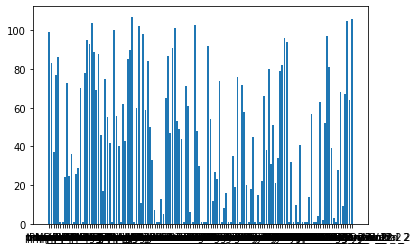

In [384]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot


rfe = RFE(RandomForestRegressor(random_state=1), n_features_to_select=30)
fit = rfe.fit(features_dataset_marcos, target_df.PMDA)
# report selected features
print('Selected Features:')
names = features_dataset_marcos.columns.values
for i in range(len(fit.support_)):
    if fit.support_[i]:
        print(names[i])
# plot feature rank
names = features_dataset_marcos.columns.values
ticks = [i for i in range(len(names))]

pyplot.bar(ticks, fit.ranking_)
pyplot.xticks(ticks, names)
pyplot.show()

In [385]:
selected_feature = names[fit.support_]

In [350]:
date_time = dataset_marcos_fechas.index

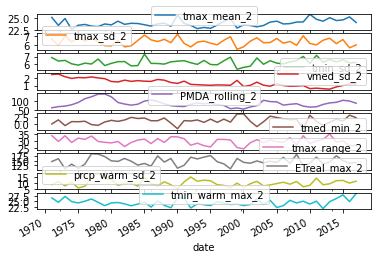

In [351]:
plot_cols = selected_feature[0:10]
plot_features = dataset_marcos_fechas[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)



In [352]:
selected_feature

array(['tmax_mean_2', 'tmax_sd_2', 'tmin_sd_2', 'vmed_sd_2',
       'PMDA_rolling_2', 'tmed_min_2', 'tmax_range_2', 'ETreal_max_2',
       'prcp_warm_sd_2', 'tmin_warm_max_2', 'tmin_warm_mean_2',
       'tmin_warm_min_2', 'tmin_warm_sd_2', 'vmed_warm_max_2',
       'tmed_warm_min_2', 'tmed_warm_normalized_2', 'tmax_warm_range_2',
       'tmin_warm_standardized_2', 'tmin_warm_normalized_2',
       'vmed_warm_log_2', 'ETreal_min_2', 'HS_max_2', 'HS_mean_2',
       'HS_min_2', 'HS_sd_2', 'HS_mad_2', 'Radiacion_max_2',
       'Radiacion_min_2', 'Radiacion_sum_2', 'Presion_max_2',
       'Presion_mean_2', 'Presion_sd_2', 'Presion_mad_2', 'Presion_sum_2',
       'day_10_mm_2', 'PMDA_1_2', 'SOI_mean_2', 'SOI_max_2', 'SOI_min_2',
       'ONI_max_2', 'ONI_min_2', 'Nino_3_4_mean_2', 'Nino_3_4_max_2',
       'PDO_mean_2', 'PDO_max_2', 'PDO_min_2', 'SOI_OND_max_2',
       'Nino_3_4_OND_mean_2', 'Nino_3_4_OND_max_2', 'PDO_OND_max_2'],
      dtype=object)

In [353]:
!pip install pca
from pca import pca
from sklearn.preprocessing import StandardScaler



In [354]:
scaler = StandardScaler()
scaled_dataset = scaler.fit_transform(features_dataset_marcos)
scaled_dataset = pd.DataFrame(scaled_dataset, columns = features_dataset_marcos.columns.to_list())

# Initialize
model = pca(n_components = .9)
# Fit transform
out = model.fit_transform(scaled_dataset)

[pca] >Processing dataframe..
[pca] >The PCA reduction is performed to capture [90.0%] explained variance using the [136] columns of the input data.
[pca] >Fitting using PCA..
[pca] >Computing loadings and PCs..
[pca] >Computing explained variance..
[pca] >Number of components is [16] that covers the [90.00%] explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[5]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]


In [355]:
 # Print the top features. The results show that f1 is best, followed by f2 etc
print(out['topfeat'])

       PC                      feature   loading  type
0     PC1                 ETreal_sum_2 -0.136875  best
1     PC2            tmed_normalized_2 -0.165229  best
2     PC3             vmed_warm_mean_2 -0.208784  best
3     PC4              tmed_warm_max_2 -0.229760  best
4     PC5                 Palmer_min_2 -0.211665  best
5     PC6                     PMDA_2_2  0.249053  best
6     PC7              tmin_warm_min_2 -0.236505  best
7     PC8                    PDO_min_2  0.258331  best
8     PC9            tmax_warm_range_2  0.227951  best
9    PC10           PMDA_log_rolling_2 -0.249214  best
10   PC11              Radiacion_mad_2  0.295521  best
11   PC12                  Palmer_sd_2 -0.269243  best
12   PC13            tmax_warm_range_2 -0.278399  best
13   PC14                     day_99_2  0.295979  best
14   PC15                   vmed_min_2  0.321773  best
15   PC16              vmed_warm_min_2  0.293634  best
16   PC17      type_category_Neutral_2  0.385863  best
17   PC18 

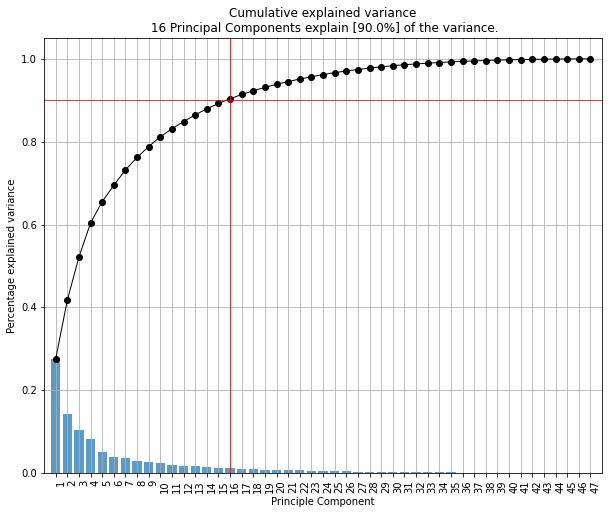

(<Figure size 720x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fa4db9393c8>)

<Figure size 432x288 with 0 Axes>

In [356]:
model.plot()

In [357]:
variables_pca = out['topfeat']
variables_pca = variables_pca[variables_pca.type == 'best'].feature.unique()

## Modelos todas las features

#### Regresión simple

In [358]:
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt


In [359]:
X = dataset_marcos.copy()
y = dataset_marcos.PMDA

X_train = X[dataset_marcos.hydro_year < 2000].drop(['PMDA', 'omm_id'], axis = 1)
X_train = X_train
y_train = dataset_marcos[dataset_marcos.hydro_year < 2000].PMDA

X_test = X[dataset_marcos.hydro_year > 2000].drop(['PMDA', 'omm_id'], axis = 1)
X_test = X_test
y_test = dataset_marcos[dataset_marcos.hydro_year > 2000].PMDA

In [360]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
fitted_model = model.fit(X_train, y_train)

In [361]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

y_train_pred = fitted_model.predict(X_train)
y_test_pred = fitted_model.predict(X_test)

mae_tr = mean_absolute_error(y_train, y_train_pred)
mae_ts = mean_absolute_error(y_test, y_test_pred)

print(f'MAE: Train error: {mae_tr}')
print(f'MAE: Test error: {mae_ts}', '\n')

r2_tr = r2_score(y_train, y_train_pred)
r2_ts = r2_score(y_test, y_test_pred)

print(f'R2: Train error: {r2_tr}')
print(f'R2: Test error: {r2_ts}', '\n')

median_abs_error_tr = median_absolute_error(y_train, y_train_pred)
median_abs_error_ts = median_absolute_error(y_test, y_test_pred)

print(f'Median Absolute Error: Train error: {median_abs_error_tr}')
print(f'Median Absolute Error: Test error: {median_abs_error_ts}', '\n')


MAE: Train error: 2.1830813019387907e-13
MAE: Test error: 31.644341302231197 

R2: Train error: 1.0
R2: Test error: -1.0648122930046853 

Median Absolute Error: Train error: 1.9895196601282805e-13
Median Absolute Error: Test error: 24.313635286218158 



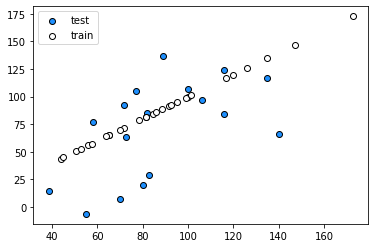

In [362]:
plt.scatter(y_test, y_test_pred, facecolor="dodgerblue", edgecolor="k", label="test")
plt.scatter(y_train, y_train_pred, facecolor="white", edgecolor="k", label="train")
#plt.plot(y, fitted_model.predict(X), color = 'red') 
#plt.plot(y_train, y_train_pred, color="tomato", label="modelo")
#plt.title(feature)
plt.legend()
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


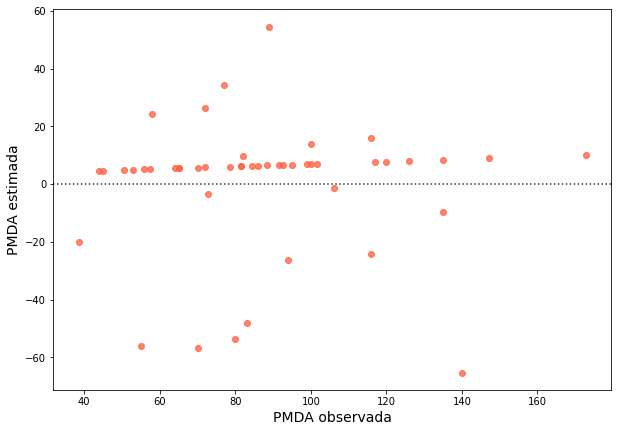

In [363]:
import seaborn as sns

df_prediction = {'y': y, 'y_pred': fitted_model.predict(X.drop(['PMDA', 'omm_id'], axis = 1))}
df_prediction = pd.DataFrame(data=df_prediction)

fig = plt.figure(figsize = (10, 7))
sns.residplot(df_prediction.y, df_prediction.y_pred, color='tomato')

# title and labels
plt.xlabel('PMDA observada', size=14)
plt.ylabel('PMDA estimada', size=14);

## Modelos con features seleccionadas

In [364]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
import numpy as np

In [365]:
#pd.plotting.scatter_matrix(dataset_marcos[['PMDA'] +  selected_feature], alpha=0.2, figsize  = [15, 15])

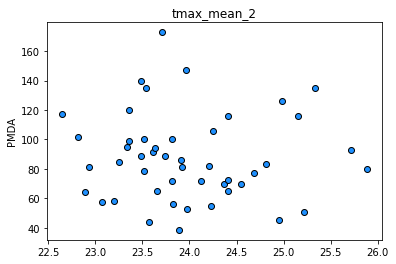

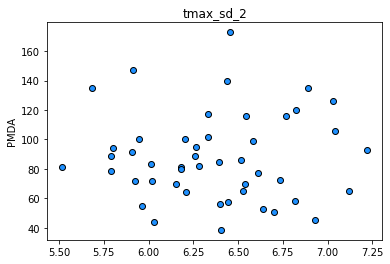

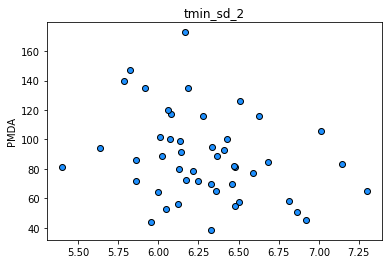

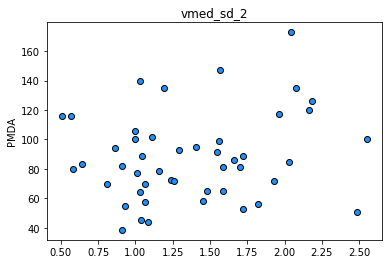

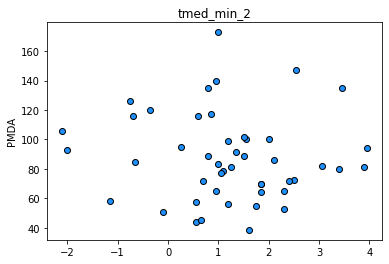

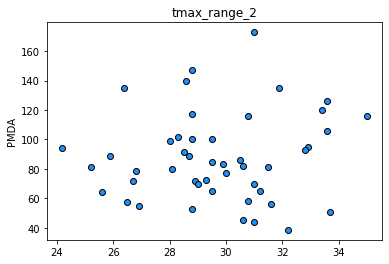

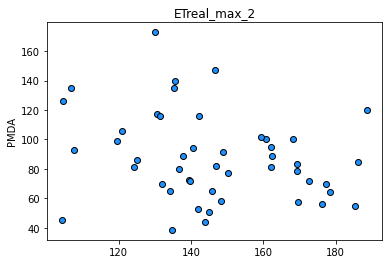

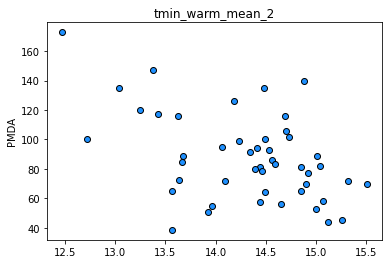

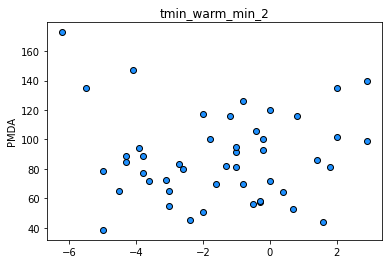

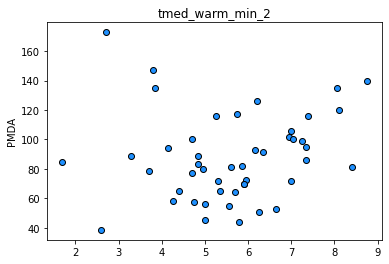

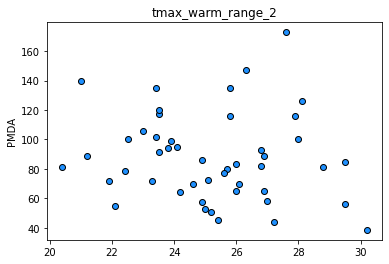

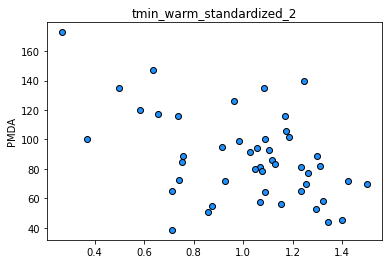

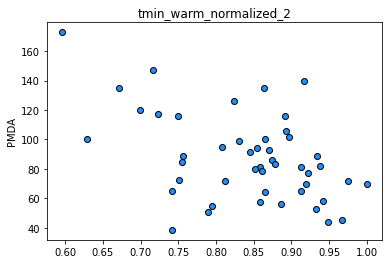

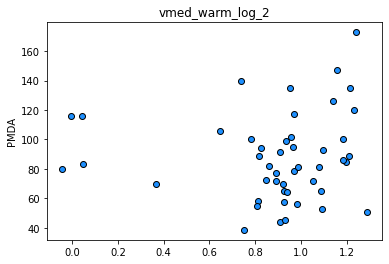

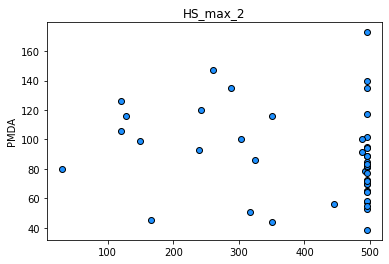

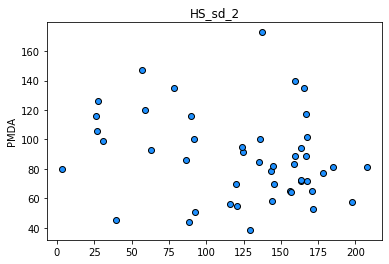

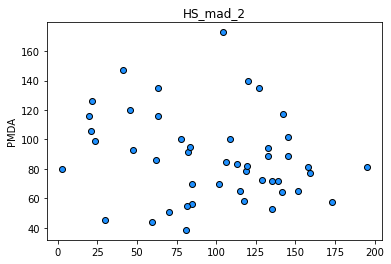

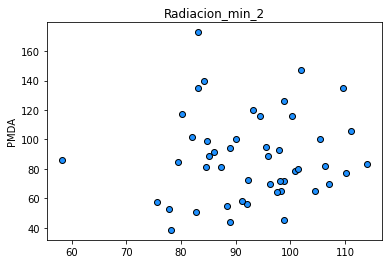

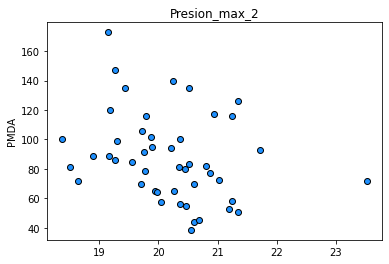

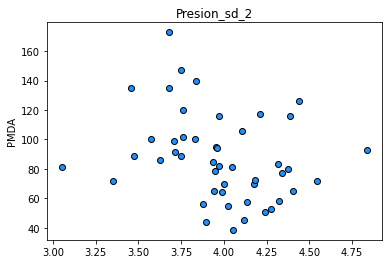

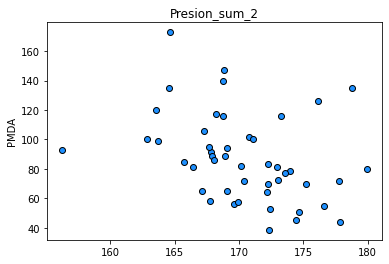

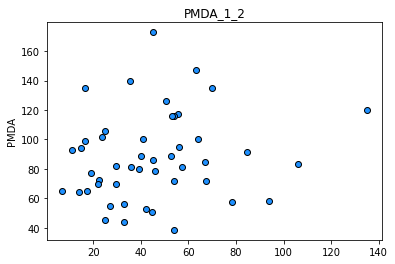

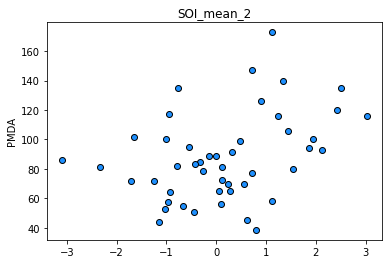

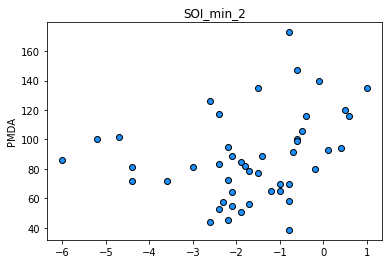

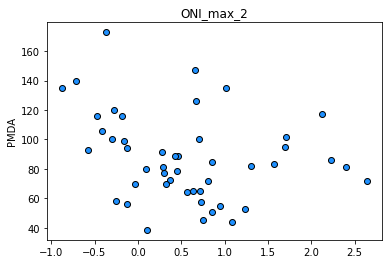

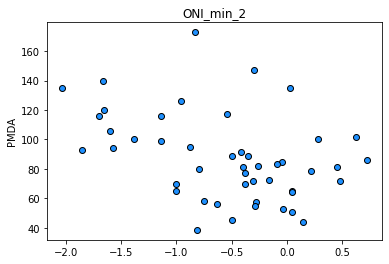

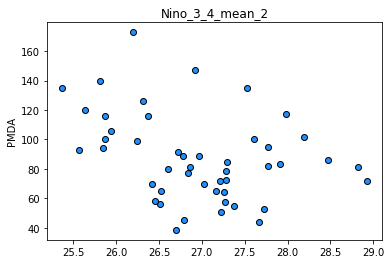

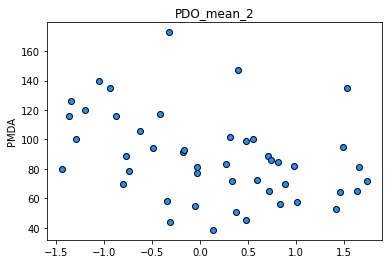

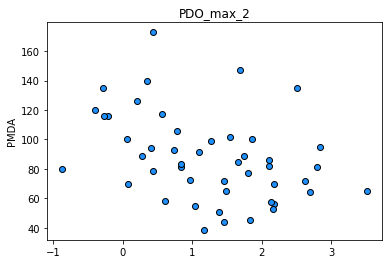

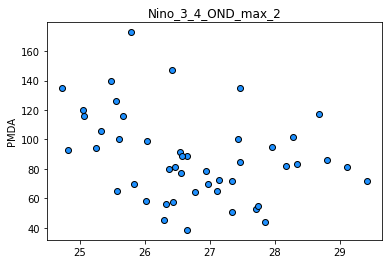

In [386]:
# Comente la parte de subplot porque no nos mostraba
# todos los gráficos

# fig = plt.figure(figsize=(30,20))
# fig.subplots_adjust(hspace=0.5, wspace=0.5)
# i = 1
for feature in selected_feature:
#      ax = fig.add_subplot(3, 5, i)
    plt.scatter(dataset_marcos.loc[:, feature], dataset_marcos['PMDA'], facecolor='dodgerblue', edgecolor='k', label='datos')
    plt.title(feature)
    plt.ylabel('PMDA')
#     i += 1
    plt.show()

In [387]:
X = dataset_marcos_fechas.copy()
y = dataset_marcos_fechas.PMDA

X_train = X[dataset_marcos_fechas.hydro_year < 1995].drop(['PMDA', 'omm_id'], axis = 1)
X_train = X_train[selected_feature] # selected_feature, features_columns, variables_pca
y_train = dataset_marcos_fechas[dataset_marcos_fechas.hydro_year < 1995].PMDA

X_test = X[dataset_marcos_fechas.hydro_year > 1995].drop(['PMDA', 'omm_id'], axis = 1)
X_test = X_test[selected_feature]
y_test = dataset_marcos_fechas[dataset_marcos_fechas.hydro_year > 1995].PMDA

In [388]:
X_train.shape

(24, 30)

In [389]:
X_train.head()

,tmax_mean_2,tmax_sd_2,tmin_sd_2,vmed_sd_2,tmed_min_2,tmax_range_2,ETreal_max_2,tmin_warm_mean_2,tmin_warm_min_2,tmed_warm_min_2,tmax_warm_range_2,tmin_warm_standardized_2,tmin_warm_normalized_2,vmed_warm_log_2,HS_max_2,HS_sd_2,HS_mad_2,Radiacion_min_2,Presion_max_2,Presion_sd_2,Presion_sum_2,PMDA_1_2,SOI_mean_2,SOI_min_2,ONI_max_2,ONI_min_2,Nino_3_4_mean_2,PDO_mean_2,PDO_max_2,Nino_3_4_OND_max_2
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1971-01-15,25.214247,6.701928,6.863639,2.488248,-0.10,33.7,145.0,13.925414,-2.0,6.25,25.2,0.858199,0.789551,1.287410,317.0,92.591437,70.277778,82.8,21.35,4.242747,174.66,44.5,-0.441667,-1.9,0.86,0.04,27.220833,0.373333,1.38,27.34
1972-01-15,23.518784,5.945842,6.429484,2.551359,1.55,29.5,160.8,12.725264,-1.8,4.70,28.0,0.370313,0.629481,1.184446,304.0,92.149212,77.833333,90.0,18.38,3.573557,162.81,41.0,1.941667,-0.6,-0.30,-1.38,25.869167,-1.295000,0.06,25.60
1973-01-15,24.981967,7.028541,6.511133,2.186552,-0.75,33.6,104.7,14.181868,-0.8,6.20,28.1,0.962453,0.823755,1.139190,120.0,27.773298,21.388889,98.9,21.34,4.438264,176.17,50.5,0.908333,-2.6,0.67,-0.96,26.318333,-1.346667,0.21,25.56
1974-01-15,22.652055,6.333339,6.081243,1.960058,0.85,28.8,130.5,13.423204,-2.0,5.75,23.5,0.654040,0.722568,0.967737,495.0,166.977657,142.402778,80.2,20.94,4.213597,168.21,55.5,-0.941667,-2.4,2.12,-0.54,27.985000,-0.412500,0.57,28.69
1975-01-15,23.539452,6.887816,5.913908,2.079873,0.80,31.9,106.9,13.044199,-5.5,3.85,25.8,0.499967,0.672019,1.212943,495.0,165.574551,127.000000,83.2,20.52,3.680391,164.56,16.5,2.508333,1.0,-0.87,-2.03,25.373333,-0.933333,-0.28,24.73


In [390]:
y_train.shape

(24,)

In [391]:
X_test.shape

(22, 30)

In [392]:
import sklearn.metrics as metrics
def regression_results(y_true, y_pred):
# Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)
    print('explained_variance: ', round(explained_variance,4))    
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

In [393]:
from sklearn.metrics import make_scorer
def rmse(actual, predict):
    predict = np.array(predict)
    actual = np.array(actual)
    distance = predict - actual
    square_distance = distance ** 2
    mean_square_distance = square_distance.mean()
    score = np.sqrt(mean_square_distance)
    return score
rmse_score = make_scorer(rmse, greater_is_better = False)

In [394]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score



In [395]:
from sklearn.preprocessing import StandardScaler, Normalizer

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
X_sc = sc.transform(X[selected_feature])

LR: -27.117545 (1.810865)
NN: -34.454167 (7.459231)
KNN: -19.844444 (7.449126)
RF: -24.769444 (4.773756)
SVR: -25.193241 (9.764251)
DT: -42.287500 (12.071923)
[20:51:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:51:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:51:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB: -28.380248 (10.446096)


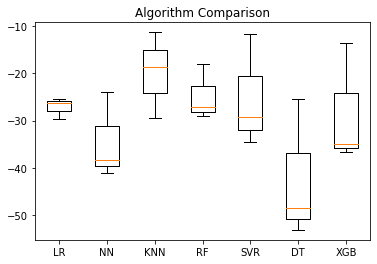

In [396]:
# Spot Check Algorithms
models = []
models.append(('LR', LinearRegression()))
models.append(('NN', MLPRegressor(solver = 'lbfgs')))  #neural network
models.append(('KNN', KNeighborsRegressor())) 
models.append(('RF', RandomForestRegressor(n_estimators = 10))) # Ensemble method - collection of many decision trees
models.append(('SVR', SVR(gamma='auto'))) # kernel = linear
models.append(('DT', DecisionTreeRegressor(max_depth = 5))) # Decision Tree
models.append(('XGB', XGBRegressor()))
# Evaluate each model in turn
results = []
names = []
for name, model in models:
    # TimeSeries Cross validation
 tscv = TimeSeriesSplit(n_splits = 3)
    
 cv_results = cross_val_score(model, X_train, y_train, cv=tscv, scoring='neg_mean_absolute_error')
 results.append(cv_results)
 names.append(name)
 print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))
    
# Compare Algorithms
plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison')
plt.show()

In [397]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
param_search = {
               #'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(param_search)

{'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [398]:
from sklearn.model_selection import GridSearchCV
model = RandomForestRegressor()

#param_search = { 
#    'n_estimators': [20, 50, 100],
#    'max_features': ['auto', 'sqrt', 'log2'],
#    'max_depth' : [i for i in range(5,15)]
#}

tscv = TimeSeriesSplit(n_splits=3)
gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=param_search, 
                       scoring = rmse_score, n_jobs = -1, verbose=2)
gsearch.fit(X_train, y_train)
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_

Fitting 3 folds for each of 432 candidates, totalling 1296 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:   38.7s
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1009 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1296 out of 1296 | elapsed:  2.0min finished


In [399]:
y_true = y_test.values
y_pred = best_model.predict(X_test)
regression_results(y_true, y_pred)

explained_variance:  0.0795
mean_squared_log_error:  0.1176
r2:  0.0578
MAE:  20.3363
MSE:  688.4071
RMSE:  26.2375


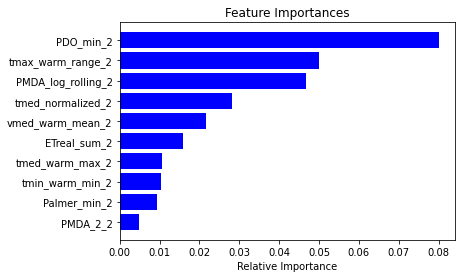

In [400]:
imp = best_model.feature_importances_[0:10]
features = X[variables_pca].columns
indices = np.argsort(imp)
plt.title('Feature Importances')
plt.barh(range(len(indices)), imp[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [401]:
features = [features[i] for i in indices]

In [402]:
PMDA_resultados = pd.DataFrame(y)
PMDA_resultados['PMDA_pred'] = best_model.predict(X_sc) # selected_feature  features_columns
PMDA_resultados.head()

,PMDA,PMDA_pred
date,,
1971-01-15,50.5,50.5
1972-01-15,100.0,100.0
1973-01-15,126.0,126.0
1974-01-15,117.0,117.0
1975-01-15,135.0,135.0


In [ ]:
PMDA_resultados.PMDA.plot()
PMDA_resultados.PMDA_pred.plot()

#### Reducir dimensiones con PCA

In [ ]:
scaler = StandardScaler()

scaled_dataset = scaler.fit_transform(X)
scaled_dataset = pd.DataFrame(scaled_dataset, columns = X.columns)

In [404]:
from sklearn import decomposition

pca = decomposition.PCA(n_components = 20)

X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

LR: -32.709050 (1.524411)
NN: -32.197530 (6.384508)
KNN: -19.844444 (7.449126)
RF: -28.267222 (8.321258)
SVR: -25.271542 (9.772780)
DT: -36.048611 (6.768042)
[20:54:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:54:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:54:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB: -29.521220 (6.226909)


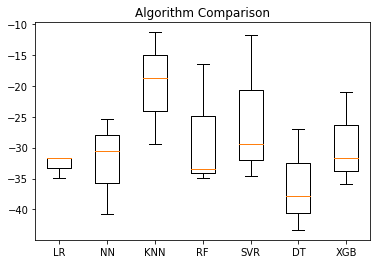

In [405]:
# Spot Check Algorithms
models = []
models.append(('LR', LinearRegression()))
models.append(('NN', MLPRegressor(solver = 'lbfgs')))  #neural network
models.append(('KNN', KNeighborsRegressor())) 
models.append(('RF', RandomForestRegressor(n_estimators = 10))) # Ensemble method - collection of many decision trees
models.append(('SVR', SVR(gamma='auto'))) # kernel = linear
models.append(('DT', DecisionTreeRegressor(max_depth = 5))) # Decision Tree
models.append(('XGB', XGBRegressor()))
# Evaluate each model in turn
results = []
names = []
for name, model in models:
    # TimeSeries Cross validation
 tscv = TimeSeriesSplit(n_splits = 3)
    
 cv_results = cross_val_score(model, X_train, y_train, cv=tscv, scoring='neg_mean_absolute_error')
 results.append(cv_results)
 names.append(name)
 print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))
    
# Compare Algorithms
plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison')
plt.show()

In [406]:
X_train = X[dataset_marcos_fechas.hydro_year < 1995].drop(['PMDA', 'omm_id'], axis = 1)
X_train = X_train[features] # selected_feature, features_columns
y_train = dataset_marcos_fechas[dataset_marcos_fechas.hydro_year < 1995].PMDA

X_test = X[dataset_marcos_fechas.hydro_year > 1995].drop(['PMDA', 'omm_id'], axis = 1)
X_test = X_test[features]
y_test = dataset_marcos_fechas[dataset_marcos_fechas.hydro_year > 1995].PMDA

In [407]:
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
X_sc = sc.transform(X[features])

### Regresión lineal

In [408]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
fitted_model = model.fit(X_train, y_train)

In [409]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error, mean_squared_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

y_train_pred = fitted_model.predict(X_train)
y_test_pred = fitted_model.predict(X_test)

mse_tr = mean_squared_error(y_train, y_train_pred)
mse_ts = mean_squared_error(y_test, y_test_pred)

print(f'MSE: Train error: {mse_tr}')
print(f'MSE: Test error: {mse_ts}', '\n')

mae_tr = mean_absolute_error(y_train, y_train_pred)
mae_ts = mean_absolute_error(y_test, y_test_pred)

print(f'MAE: Train error: {mae_tr}')
print(f'MAE: Test error: {mae_ts}', '\n')

r2_tr = r2_score(y_train, y_train_pred)
r2_ts = r2_score(y_test, y_test_pred)

print(f'R2: Train error: {r2_tr}')
print(f'R2: Test error: {r2_ts}', '\n')

median_abs_error_tr = median_absolute_error(y_train, y_train_pred)
median_abs_error_ts = median_absolute_error(y_test, y_test_pred)

print(f'Median Absolute Error: Train error: {median_abs_error_tr}')
print(f'Median Absolute Error: Test error: {median_abs_error_ts}', '\n')

mean_sq_error_tr = mean_squared_error(y_train, y_train_pred)
mean_sq_error_ts = mean_squared_error(y_test, y_test_pred)

MSE: Train error: 225.43898048697898
MSE: Test error: 2644.0994047104323 

MAE: Train error: 12.206014660540342
MAE: Test error: 42.40991333000565 

R2: Train error: 0.7558737483084502
R2: Test error: -2.6187267953243643 

Median Absolute Error: Train error: 10.102512279626975
Median Absolute Error: Test error: 35.645944568637674 



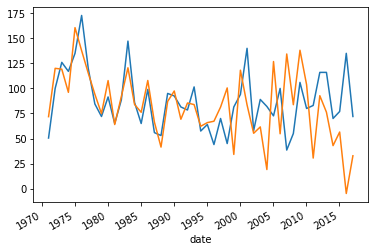

In [410]:
PMDA_resultados = pd.DataFrame(y)
PMDA_resultados['PMDA_pred'] = fitted_model.predict(X_sc) # selected_feature  features_columns
PMDA_resultados.PMDA.plot()
PMDA_resultados.PMDA_pred.plot()

In [411]:
PMDA_resultados.to_csv('marcos_juarez_lineal.csv')

### Random Forest

In [412]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler

#sc = StandardScaler()
#X_train = sc.fit_transform(X_train)
#X_test = sc.transform(X_test)

In [413]:
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(n_estimators=20, random_state=0)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

In [414]:
from sklearn import metrics

y_train_pred = regressor.predict(X_train)
y_test_pred = regressor.predict(X_test)

mse_tr = mean_squared_error(y_train, y_train_pred)
mse_ts = mean_squared_error(y_test, y_test_pred)

print(f'MSE: Train error: {mse_tr}')
print(f'MSE: Test error: {mse_ts}', '\n')

mae_tr = mean_absolute_error(y_train, y_train_pred)
mae_ts = mean_absolute_error(y_test, y_test_pred)

print(f'MAE: Train error: {mae_tr}')
print(f'MAE: Test error: {mae_ts}', '\n')

r2_tr = r2_score(y_train, y_train_pred)
r2_ts = r2_score(y_test, y_test_pred)

print(f'R2: Train error: {r2_tr}')
print(f'R2: Test error: {r2_ts}', '\n')

median_abs_error_tr = median_absolute_error(y_train, y_train_pred)
median_abs_error_ts = median_absolute_error(y_test, y_test_pred)

print(f'Median Absolute Error: Train error: {median_abs_error_tr}')
print(f'Median Absolute Error: Test error: {median_abs_error_ts}', '\n')



MSE: Train error: 206.96621666666667
MSE: Test error: 897.6894850454545 

MAE: Train error: 9.082083333333333
MAE: Test error: 23.573227272727273 

R2: Train error: 0.7758777714817922
R2: Test error: -0.22858202215384327 

Median Absolute Error: Train error: 5.380000000000003
Median Absolute Error: Test error: 21.2975 



#### Hyperparameters tuning

In [415]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(random_state = 42)
from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [417]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [418]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, 
                               param_distributions = random_grid, n_iter = 100, 
                               cv = 10, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   43.8s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed: 10.1min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 16.0min finished


RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                             

In [419]:
rf_random.best_params_


{'bootstrap': False,
 'max_depth': 70,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 1600}

In [420]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} .'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

base_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
base_model.fit(X_train, y_train)
base_accuracy = evaluate(base_model, X_test, y_test)



Model Performance
Average Error: 21.6432 .
Accuracy = 65.72%.


In [421]:
best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_test, y_test)

print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Model Performance
Average Error: 22.4049 .
Accuracy = 65.65%.
Improvement of -0.10%.


In [422]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [ ]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 4320 candidates, totalling 12960 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   36.7s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  2.8min


In [ ]:
best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, X_test, y_test)

print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))

In [ ]:
PMDA_resultados = pd.DataFrame(y)
PMDA_resultados['PMDA_pred'] = best_grid.predict(X_sc) # selected_feature  features_columns
PMDA_resultados.PMDA.plot()
PMDA_resultados.PMDA_pred.plot()

### Decision Tree

In [177]:
from sklearn.tree import DecisionTreeRegressor

# Create a random dataset
rng = np.random.RandomState(1)

# Fit regression model
regr_1 = DecisionTreeRegressor(max_depth=2)
regr_1.fit(X_train, y_train)


DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [179]:
# Predict
y_train_pred = regr_1.predict(X_train)
y_test_pred = regr_1.predict(X_test)
#y_2 = regr_2.predict(X_test)

mse_tr = mean_squared_error(y_train, y_train_pred)
mse_ts = mean_squared_error(y_test, y_test_pred)

print(f'MSE: Train error: {mse_tr}')
print(f'MSE: Test error: {mse_ts}', '\n')

mae_tr = mean_absolute_error(y_train, y_train_pred)
mae_ts = mean_absolute_error(y_test, y_test_pred)

print(f'MAE: Train error: {mae_tr}')
print(f'MAE: Test error: {mae_ts}', '\n')

r2_tr = r2_score(y_train, y_train_pred)
r2_ts = r2_score(y_test, y_test_pred)

print(f'R2: Train error: {r2_tr}')
print(f'R2: Test error: {r2_ts}', '\n')

median_abs_error_tr = median_absolute_error(y_train, y_train_pred)
median_abs_error_ts = median_absolute_error(y_test, y_test_pred)

print(f'Median Absolute Error: Train error: {median_abs_error_tr}')
print(f'Median Absolute Error: Test error: {median_abs_error_ts}', '\n')



MSE: Train error: 910.505541378205
MSE: Test error: 2564.1965469144566 

MAE: Train error: 24.07083333333333
MAE: Test error: 33.288731060606054 

R2: Train error: 0.4333402742710841
R2: Test error: -1.4831975170300309 

Median Absolute Error: Train error: 18.34391666666666
Median Absolute Error: Test error: 14.0 



#### Hyperparameters tuning

In [180]:
dtr = DecisionTreeRegressor(random_state = 42)
from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(dtr.get_params())

Parameters currently in use:

{'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': 42,
 'splitter': 'best'}


In [181]:
from sklearn.model_selection import RandomizedSearchCV

# Number of features to consider at every split
max_features = list(range(1,X_train.shape[1]))
# Maximum number of levels in tree
max_depths = np.linspace(1, 32, 32, endpoint=True)
# Minimum number of samples required to split a node
min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
# Minimum number of samples required at each leaf node
min_samples_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)

# Create the random grid
random_grid = {'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
pprint(random_grid)

{'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': [1, 2, 3, 4, 5, 6, 7, 8, 9],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10]}


In [182]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
#rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
dtr_random = RandomizedSearchCV(estimator = dtr, param_distributions = random_grid, 
                                n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
dtr_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 278 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.6s finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=DecisionTreeRegressor(ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features=None,
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   presort='deprecated',
                                                   random_state=42,
                                                   splitter='best'),
                   iid='dep

In [183]:
dtr_random.best_params_


{'max_depth': 50,
 'max_features': 4,
 'min_samples_leaf': 1,
 'min_samples_split': 5}

In [184]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

base_model = DecisionTreeRegressor(random_state = 42)
base_model.fit(X_train, y_train)
base_accuracy = evaluate(base_model, X_test, y_test)

best_random = dtr_random.best_estimator_
random_accuracy = evaluate(best_random, X_test, y_test)

print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Model Performance
Average Error: 39.7292 degrees.
Accuracy = 47.84%.
Model Performance
Average Error: 34.6986 degrees.
Accuracy = 58.82%.
Improvement of 22.95%.


In [185]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
# Create a based model
dtr = DecisionTreeRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = dtr, param_grid = param_grid, 
                          cv = 3, verbose = 2, n_jobs = -1)

In [186]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 972 candidates, totalling 2916 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 1084 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 2916 out of 2916 | elapsed:    4.5s finished


{'max_depth': 30,
 'max_features': 2,
 'min_samples_leaf': 2,
 'min_samples_split': 5}

In [187]:
best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, X_test, y_test)

print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))

Model Performance
Average Error: 24.6731 degrees.
Accuracy = 71.34%.
Improvement of 49.13%.


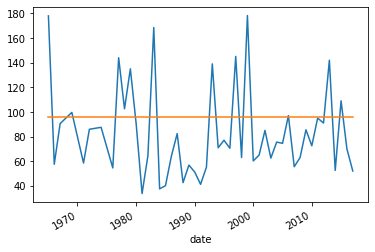

In [188]:
PMDA_resultados = pd.DataFrame(y)
PMDA_resultados['PMDA_pred'] = best_grid.predict(X_sc) # selected_feature  features_columns
PMDA_resultados.PMDA.plot()
PMDA_resultados.PMDA_pred.plot()

## XGBoost

In [189]:
import xgboost
import csv as csv
from xgboost import plot_importance
from matplotlib import pyplot
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import  train_test_split
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV   #Perforing grid search
from scipy.stats import skew
from collections import OrderedDict

In [193]:
#every_column_except_y= [col for col in train_dataset.columns if col not in ['SalePrice','Id']]
#model.fit(X_train, y_train)

#for tuning parameters
parameters_for_testing = {
    'colsample_bytree':[0.4,0.6,0.8],
    'gamma':[0,0.03,0.1,0.3],
    'min_child_weight':[1.5,6,10],
    'learning_rate':[0.1,0.07],
    'max_depth':[3,5],
    'n_estimators':[2, 5, 10, 20],
    'reg_alpha':[1e-5, 1e-2,  0.75],
    #'reg_lambda':[1e-5, 1e-2, 0.45],
    'subsample':[0.6,0.95]  
}



In [194]:
xgb_model = xgboost.XGBRegressor(seed=27)

gsearch1 = GridSearchCV(estimator = xgb_model, param_grid = parameters_for_testing, 
                        n_jobs = -1, iid=False, verbose=2,
                        scoring='neg_mean_squared_error', cv = 3)
gsearch1.fit(X_train,y_train)


Fitting 3 folds for each of 3456 candidates, totalling 10368 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 296 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 4168 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done 10334 tasks      | elapsed:   46.5s
[Parallel(n_jobs=-1)]: Done 10368 out of 10368 | elapsed:   46.7s finished


[19:34:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


GridSearchCV(cv=3, error_score=nan,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objective='reg:linear', random_state=0,
                                    reg_alpha=0, reg_...
                                    subsample=1, verbosity=1),
             iid=False, n_jobs=-1,
             param_grid={'colsample_bytree': [0.4, 0.6, 0.8],
                         'gamma': [0, 0.03, 0.1, 0.3],
                         'learning_rate': [0.1, 0.07], 'max_depth': [3, 5],
                         'min_chil

In [195]:
#gsearch1.
#print (gsearch1.grid_scores_)
print('best params')
print (gsearch1.best_params_)
print('best score')
print (gsearch1.best_score_)

best params
{'colsample_bytree': 0.4, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 10, 'n_estimators': 20, 'reg_alpha': 1e-05, 'subsample': 0.95}
best score
-1872.1476697329133


In [198]:

best_xgb_model = xgboost.XGBRegressor(colsample_bytree = 0.4, 
                                      gamma = 0, 
                                      learning_rate = 0.1, 
                                      max_depth = 3, 
                                      min_child_weight = 10, 
                                      n_estimators = 20, 
                                      reg_alpha = 1e-05, 
                                      subsample =  0.95,
                 seed=42)
best_xgb_model.fit(X_train,y_train)

[19:37:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=10, missing=None, n_estimators=20,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=1e-05, reg_lambda=1, scale_pos_weight=1, seed=42,
             silent=None, subsample=0.95, verbosity=1)

In [199]:
# Predict
y_train_pred = best_xgb_model.predict(X_train)
y_test_pred = best_xgb_model.predict(X_test)

mse_tr = mean_squared_error(y_train, y_train_pred)
mse_ts = mean_squared_error(y_test, y_test_pred)

print(f'MSE: Train error: {mse_tr}')
print(f'MSE: Test error: {mse_ts}', '\n')

mae_tr = mean_absolute_error(y_train, y_train_pred)
mae_ts = mean_absolute_error(y_test, y_test_pred)

print(f'MAE: Train error: {mae_tr}')
print(f'MAE: Test error: {mae_ts}', '\n')

r2_tr = r2_score(y_train, y_train_pred)
r2_ts = r2_score(y_test, y_test_pred)

print(f'R2: Train error: {r2_tr}')
print(f'R2: Test error: {r2_ts}', '\n')

median_abs_error_tr = median_absolute_error(y_train, y_train_pred)
median_abs_error_ts = median_absolute_error(y_test, y_test_pred)

print(f'Median Absolute Error: Train error: {median_abs_error_tr}')
print(f'Median Absolute Error: Test error: {median_abs_error_ts}', '\n')


MSE: Train error: 1353.5548042579358
MSE: Test error: 1454.9308792323636 

MAE: Train error: 25.855420009906478
MAE: Test error: 27.66348245794123 

R2: Train error: 0.15760535297910894
R2: Test error: -0.4089718477733577 

Median Absolute Error: Train error: 16.55578890991211
Median Absolute Error: Test error: 21.415578842163086 



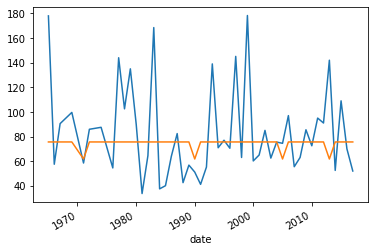

In [200]:
PMDA_resultados = pd.DataFrame(y)
PMDA_resultados['PMDA_pred'] = best_xgb_model.predict(X_sc) # selected_feature  features_columns
PMDA_resultados.PMDA.plot()
PMDA_resultados.PMDA_pred.plot()

In [146]:
PMDA_resultados.to_csv('resultados__xgboost_la_florida.csv')